In [2]:
using DrWatson
@quickactivate("Quantum Three-Level Maser")
# using Pkg
# Pkg.resolve()
# Pkg.update()
# Pkg.instantiate()
# Pkg.add(["LaTeXStrings", "QuantumOptics", "CairoMakie", "SparseArrays", "LinearAlgebra"])
using LaTeXStrings
using CairoMakie
using SparseArrays
using Revise
using QuantumOptics
using QuantumFCS
using LinearAlgebra
import QuantumFCS: drazin_apply

include("../src/quantum-TLM_functions.jl")
using .QuantumTLMFunctions

# Bind module functions into Main so existing notebook names work unchanged
for name in (:liouvQTLM, :liouvQTLM_adb, :liouv_semiclassical, :adiabatic_elimination, :noise_drazin, :var_dotN, :set_broken_axis!, :add_figure_break_indicators!, :nB, :nBtoTω)
    @eval Main $(name) = QuantumTLMFunctions.$(name)
end


We consider a three-level system embedded in a driven cavity~\cite{Li2017, Max2025}.
In the rotating frame relative to the drive frequency, the dynamics is governed by the time-independent Lindblad equation,
\begin{align}
    \frac{\text{d}}{\text{d}t}{\rho} = -i[H, \rho] +\mathcal{L}_H\rho +\mathcal{L}_C\rho +\mathcal{L}_{\rm cav}\rho\nonumber,
\end{align}
with Hamiltonian,
\begin{align}
    H = \Delta |2\rangle\!\langle 2| +  \Delta a^\dagger a + g(a^\dagger |1\rangle\!\langle 2| + a|2\rangle\!\langle 1|) +i\mathcal{E}(a - a^\dagger)\nonumber,
\end{align}
and thermal dissipators,
\begin{align}
    \mathcal{L}_H\rho &=\gamma_H (\bar{n}_H+1) D[|1\rangle\!\langle 3|]\rho + \gamma_H \bar{n}_H D[|3\rangle\!\langle 1|]\rho,\nonumber\\
    \mathcal{L}_C\rho &=\gamma_C (\bar{n}_C+1) D[|2\rangle\!\langle 3|]\rho + \gamma_C \bar{n}_C D[|3\rangle\!\langle 2|]\rho,\nonumber\\
    \mathcal{L}_\text{cav}\rho &= \kappa (\bar{n}_\text{cav}+1) D[a]\rho + \kappa \bar{n}_\text{cav} D[a^\dagger]\rho\nonumber.
\end{align}.
Furthermore, we have $\mathcal{E}= f\sqrt{\kappa}$, where $f = \langle b_\text{in}\rangle \in \text{R}$.

We also consider the semi-classical model from Patrick's paper. In this case, the correspondence is stablished in the limit strong-drive limit $\mathcal{E} \gg \kappa \gg f$, leading to a wave-like behaviour. In that case, the three-level system is effectively driven with strenght,
\begin{align}
 \mathcal{E}' = -2t_c\frac{g}{\kappa} \mathcal{E}, \nonumber.
\end{align}

We use QuantumFCS.jl to compute the average and variance of the heat currents flowing across the system,
\begin{align}
\langle J_i\rangle,~ \langle\!\langle J_i^2\rangle\!\rangle,~i=\text{H, C, cav}. \nonumber
\end{align}

The weights of each heat current are given by,
\begin{align}
\nu_\text{H} &= \{-\omega_3,~ \omega_3\},\nonumber\\
\nu_\text{C} &= \{-(\omega_3-\omega_2),~(\omega_3-\omega_2)\},\nonumber\\
\nu_\text{cav} &= \{-\omega_\text{cav},~\omega_\text{cav}\}\nonumber.
\end{align}

In [3]:
N = 30
b_tls = NLevelBasis(3)
b_fock = FockBasis(N)
σs = [transition(b_tls, i, j) for i=1:3, j =1:3];
a = destroy(b_fock)
ad = create(b_fock)
Id_cav = one(b_fock)
Id_tls = one(b_tls)

Jumps = [Id_cav⊗σs[1, 3], Id_cav⊗σs[2, 3], a⊗Id_tls, Id_cav⊗σs[3, 1], Id_cav⊗σs[3, 2], ad⊗Id_tls]
;

# Simulations varying $\bar{n}$ and $g/\kappa$

Here we consider going to a limit of high effective field, $\mathcal{E}'=4g \mathcal{E}/\kappa$. We can do it by tuning $g/\kappa$, or $\mathcal{E}/\kappa$. The latter blows up the Hilbert space truncation easily. The objective is to curb the vacuum fluctuations in the cavity mode and increase the photon-number, so that the particle nature of light is irrelevant. In this limit we expect to recover the semi-classical model, where the Lindblad dissipator of the cavity mode is irrelevant.

In [4]:
g =  0.025 
f = 1.5
Δ = 0.0
γH = 0.1
γC = 2.0
κ = 1.0
ℰ  = √κ*f
ℰp  =  -2g * ℰ / κ

TH = 1e9
Tcav= 2000.0
TC = Tcav 
Ω = ω2 = 3500.0
ω3 = 3*ω2

nC = nB(ω3 - Ω,TC)
ncav = nB(Ω,Tcav) 
nH = nB(ω3,TH)

println("ℰ = $ℰ, κ = $κ, g = $g, f = $f, ℰp = $ℰp,  ncav = $ncav")
println("α = $ℰp")

delta_power(a_avg) = - ℰ* Ω * (a + ad) + ℰ * Ω * (a_avg + conj(a_avg))*Id_cav
delta_power_io(a_avg) =  delta_power(a_avg) - Ω *(κ/2) *(conj(a_avg) * a + a_avg * ad - 2 * abs(a_avg)^2*Id_cav)  

ℰ = 1.5, κ = 1.0, g = 0.025, f = 1.5, ℰp = -0.07500000000000001,  ncav = 0.21032251654728903
α = -0.07500000000000001


delta_power_io (generic function with 1 method)

In [5]:
nHrange = range(0.5, length=100, stop=10)
Trange = @. nBtoTω(nHrange)*ω3
the_range = nHrange 

# Average currents
JH_n = similar(the_range)
JC_n = similar(the_range)
P_sc_n = similar(the_range)
JC_sc_n = similar(the_range)
JH_sc_n = similar(the_range)
Jcav_n = similar(the_range)
Jcavio_n = similar(the_range)


P_n = similar(the_range)
Pio_n = similar(the_range)

# Noise
DC_n = similar(the_range)
DH_n = similar(the_range)
Dcav_n = similar(the_range)
DP_n = similar(the_range)
DP_sc_n = similar(the_range)
DP_io_n = similar(the_range)

Σ_n = similar(the_range)
Σio_n = similar(the_range)
Σ_sc_n = similar(the_range);

P_matrix = zeros(length(the_range), N + 1)

nCp = nB(ω3 - Ω, TC)
ncavp = nB(Ω, Tcav)


for j=1:length(the_range)
    nHp = nHrange[j]
    
    # Exact model
    rates = [√γH*√(nHp + 1), √γC√(nCp + 1), √κ√(ncavp + 1), √γH*√nHp, √γC*√nCp, √κ*√ncavp]
    H, J =  liouvQTLM(Δ, g, ℰ, Jumps, rates)
    ρss = steadystate.iterative(H, J)
    ρss = SparseOperator(ρss)
    ρ_cav = ptrace(ρss, 2)
    P_matrix[j, :] = real.(diag(ρ_cav.data))

    ρtls = ptrace(ρss, 1).data
    p1, p2, p3 = ρtls[1,1], ρtls[2,2], ρtls[3,3]
    JH = ω3 * γH * (nHp*p1 -(nHp + 1)p3)
    # JC = (ω3 - ω2) * γC * (nCp*p2 -(nCp + 1)p3)
    
    a_avg = tr(a ⊗ Id_tls * ρss)
    n_avg = tr(ad*a ⊗ Id_tls * ρss)

    # Jcav= Ω * κ * (ncavp - n_avg)
    # Jcavio = Jcav .+  Ω * κ * abs(a_avg)^2

    mJH= [J[1], J[4]]
    mJC= [J[2], J[5]]
    mJcav = [J[3], J[6]]

    nu = [-ω3 + Ω, ω3 - Ω]
    JC, DC = fcscumulants_recursive(H, J, mJC, 2, ρss, nu)

    a_avg = tr(a⊗Id_tls*ρss)
    n_avg = tr(ad*a⊗Id_tls*ρss)
    Jcav= Ω * κ * (ncavp - n_avg)
    Jcavio = Jcav .+  Ω * κ   * abs(a_avg)^2

    # P_n[j] = real(-JC - JH - Jcav)
    # P_n[j] = real(1im * ℰ * Ω * ((conj(a_avg) - a_avg)))
    P_n[j] = real(-ℰ * Ω * ((conj(a_avg) + a_avg)))
    # Pio_n[j] = real(1im * ℰ * Ω * ((conj(a_avg) - a_avg)) -  Ω * κ * abs(a_avg)^2)
    Pio_n[j] = real(-ℰ * Ω * ((conj(a_avg) + a_avg)) -  Ω * κ * abs(a_avg)^2)
    
    Jcavio_n[j] = real(Jcavio)
    Jcav_n[j] = real(Jcav)
    JC_n[j] = real(JC)
    JH_n[j] = real(JH)

    δP = delta_power(a_avg)
    δPio = delta_power_io(a_avg)
    Pnoise = noise_drazin(δP⊗Id_tls, H, J, ρss)
    Pionoise = noise_drazin(δPio⊗Id_tls, H, J, ρss)
    # println(Pnoise/Pionoise)

    DP_n[j] = real(Pnoise)
    DP_io_n[j] = real(Pionoise)
    DC_n[j] = real(DC)

    Σ_n[j] =  real(-JH/Trange[j] - JC/TC - Jcav /Tcav)
    Σio_n[j] =   real(-JH/Trange[j] - JC/TC - Jcavio /Tcav)

    # Semiclassical model
    rates_sc = [√γH*√(nHp + 1), √γC√(nCp + 1), √γH*√nHp, √γC*√nCp]
    ℰp = -2g * ℰ / κ    
    H_sc, J_sc =  liouv_semiclassical(Δ, ℰp, rates_sc)
    ρss_sc = steadystate.eigenvector(H_sc, J_sc)
    ρss_sc = SparseOperator(ρss_sc)
    mJC_sc= [J_sc[2], J_sc[4]]

    I_sc, DI_sc = fcscumulants_recursive(H_sc, J_sc, mJC_sc, 2, ρss_sc, [-1, 1])
    # I_sc = fcscumulants_recursive(H_sc, J_sc, mJC_sc, 1, ρss_sc; nu = [-1, 1])[1]
    P_sc = Ω * I_sc
    DP_sc = Ω^2 * DI_sc

    # F_sc = abs(DP_sc/P_sc)/Ω
    Σ_sc =   -P_sc * log(nHp * (nCp + 1) / ((nHp + 1) * nCp))/Ω

    P_sc_n[j] = real(P_sc)
    JC_sc_n[j] = (ω3 - Ω) * real(I_sc)
    JH_sc_n[j] = -(ω3) * real(I_sc)
    DP_sc_n[j] = real(DP_sc)
    Σ_sc_n[j] = real(Σ_sc)

end

SNRC = @. DC_n / JC_n^2
SNRP_sc = @. DP_sc_n / (P_sc_n^2)

𝒬C = @. SNRC * Σ_n
𝒬Cio = @. SNRC * Σio_n
𝒬P_sc = @. SNRP_sc * Σ_sc_n

SNRC = @. DC_n / JC_n^2
SNRP_sc = @. DP_sc_n / (P_sc_n^2)


𝒬C = @. SNRC * Σ_n
𝒬Cio = @. SNRC * Σio_n

# Signal-to-noise ratios for power
SNRP = @. DP_n / (P_n^2)
SNRPio = @. DP_io_n / (Pio_n^2)
SNRPsc = @. DP_sc_n / (P_sc_n^2)

# Q-factors for power
𝒬P = @. SNRP * Σ_n
𝒬Pio = @. SNRPio * Σio_n
𝒬P_sc = @. SNRP_sc * Σ_sc_n
;

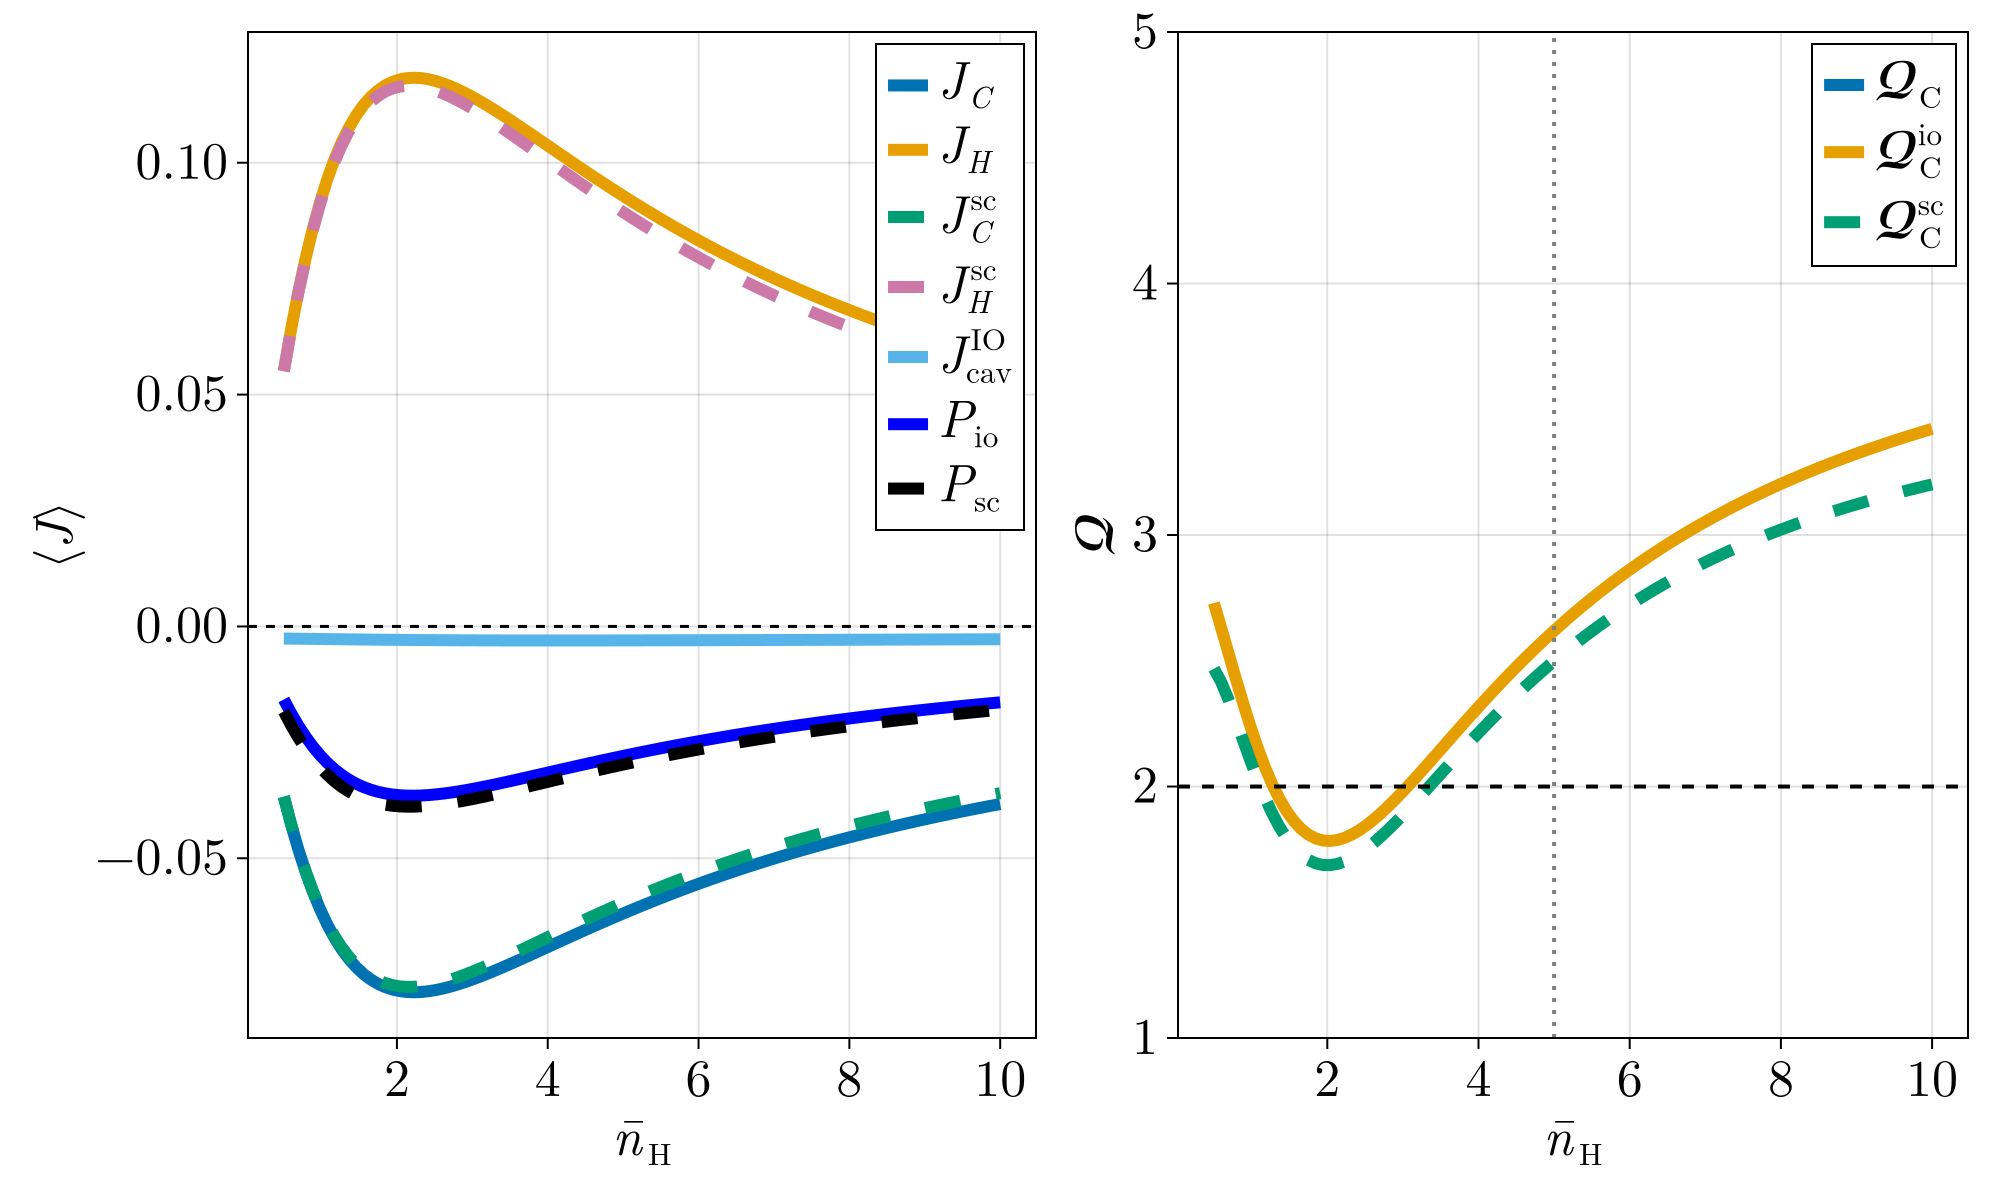

In [6]:
qtlm_plots = with_theme(theme_latexfonts()) do
    lw=6
        #|=== === === === Layout
            f = Figure(fontsize = 26, size = (1000, 600))
            c_P = :blue
            c_J = :red
            ga = f[1,1] = GridLayout()
            # gb = f[2,1] = GridLayout()
            # gc = f[2,1] = GridLayout()
            gd = f[1,2] = GridLayout()

            # xscale = log10
            xscale = identity

            # yscale = identity
            yscale = Makie.pseudolog10

            # #|=== === ===  Fig. (a)
            axa = Axis(ga[1,1], xscale = xscale, ylabel = L"\langle J \rangle", xlabel =L"\bar{n}_\text{H}")
            lines!(axa, the_range, JC_n/Ω, linewidth = lw, label = L"J_C")
            lines!(axa, the_range, JH_n/Ω, linewidth = lw, label = L"J_H")
            lines!(axa, the_range, JC_sc_n/Ω, linewidth = lw, label = L"J_C^\text{sc}", linestyle = :dash)
            # lines!(axa, the_range, JC_adb/Ω, linewidth = lw, label = L"J_C^\text{adb}", linestyle = :dot)
            lines!(axa, the_range, JH_sc_n/Ω, linewidth = lw, label = L"J_H^\text{sc}", linestyle = :dash)
            lines!(axa, the_range, Jcavio_n/Ω, linewidth = lw, label = L"J_\text{cav}^\text{IO}" )
            # lines!(axa, the_range, Jcavio_adb/Ω, linewidth = lw, label = L"J_\text{cav}^\text{IO,adb}", linestyle = :dot)
            # lines!(axa, the_range, Jcav_n/Ω, linewidth = lw, color = c_J, label = L"J_\text{cav}")
            lines!(axa, the_range, Pio_n/Ω, linewidth = lw, color = c_P, label = L"P_\text{io}")
            # lines!(axa, the_range, Pio_adb/Ω, linewidth = lw, label = L"P_\text{io}^\text{adb}", linestyle = :dot)
            # lines!(axa, the_range, P_n/Ω, linewidth = lw, color = c_P, label = L"P", linestyle = :dash)
            lines!(axa, the_range, P_sc_n/Ω, linewidth = lw, color = :black, label = L"P_\text{sc}", linestyle = :dash)
            # lines!(axa, the_range, P_n/Ω + JC_n/Ω + JH_n/Ω + Jcav_n/Ω, label = "Check")
            hlines!(axa, 0, color = :black, linestyle = :dash)
            axislegend(axa, position= (1,1))
            # hidexdecorations!(axa)
            # axa.xgridvisible = true

        axd = Axis(gd[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = L"\mathcal{Q}",
            xscale = xscale)
        lines!(axd, the_range, 𝒬C, linewidth = lw, label = L"\mathcal{Q}_\text{C}")
        lines!(axd, the_range, 𝒬Cio, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{io}")
        # lines!(axd, the_range, 𝒬Cio, linewidth = lw, label = L"\mathcal{Q}_\text{C,io}", linestyle = :dash)
        # lines!(axd, the_range, 𝒬cav, linewidth = lw, label = L"\mathcal{Q}_\text{cav}", linestyle = :dot)
        # lines!(axd, the_range, 𝒬cavio, linewidth = lw, label = L"\mathcal{Q}_\text{cav,io}", linestyle = :dot)
        lines!(axd, the_range, 𝒬P_sc, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{sc}", linestyle = :dash)
        hlines!(axd, 2, color = :black, linestyle = :dash, linewidth = 2.0)
        vlines!(axd, 5, color = :grey, linestyle = :dot, linewidth = 2.0)
        axislegend(axd, position = (1,1))
        # axd.ygridvisible = true
        ylims!(axd, 1, 5)

        # ge = f[2,1] = GridLayout()
        # axe = Axis(ge[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = "Power noise",
        #     xscale = xscale)
        # # lines!(axe, the_range, 𝒬P, linewidth = lw, label = L"\mathcal{Q}_P")
        # lines!(axe, the_range, DP_n/Ω^2, linewidth = lw, label = L"D_P")
        # lines!(axe, the_range, DP_io_n/Ω^2, linewidth = lw, label = L"D_P^\text{io}")
        # lines!(axe, the_range, DP_sc_n/Ω^2, linewidth = lw, label = L"D_P^\text{sc}", linestyle = :dash)
        # # lines!(axe, the_range, 𝒬Pio, linewidth = lw, label = L"\mathcal{Q}_P^\text{io}")
        # # hlines!(axe, 2, color = :black, linestyle = :dash, linewidth = 2.0)
        # # axislegend(axe, position = (1,.5))
        # # ylims!(axe, 0, 10)
        # # ylims!(axe, 1.5, 3)

        # gf = f[2,2] = GridLayout()
        # axf = Axis(gf[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = "Power SNR",
        #     xscale = xscale)
        # # lines!(axe, the_range, 𝒬P, linewidth = lw, label = L"\mathcal{Q}_P")
        # lines!(axf, the_range, SNRP, linewidth = lw, label = L"D_P")
        # lines!(axf, the_range, SNRPio, linewidth = lw, label = L"D_P^\text{io}", linestyle = :dash)
        # lines!(axf, the_range, SNRPsc, linewidth = lw, label = L"D_P^\text{sc}")
        # # lines!(axe, the_range, 𝒬Pio, linewidth = lw, label = L"\mathcal{Q}_P^\text{io}")
        # # hlines!(axe, 2, color = :black, linestyle = :dash, linewidth = 2.0)
        # # axislegend(axe, position = (1,.5))
        # ylims!(axf, 0, 10)
        # current_figure()
        f
    end
        

## Tentative analysis of IO-power fluctuations. Unpublished

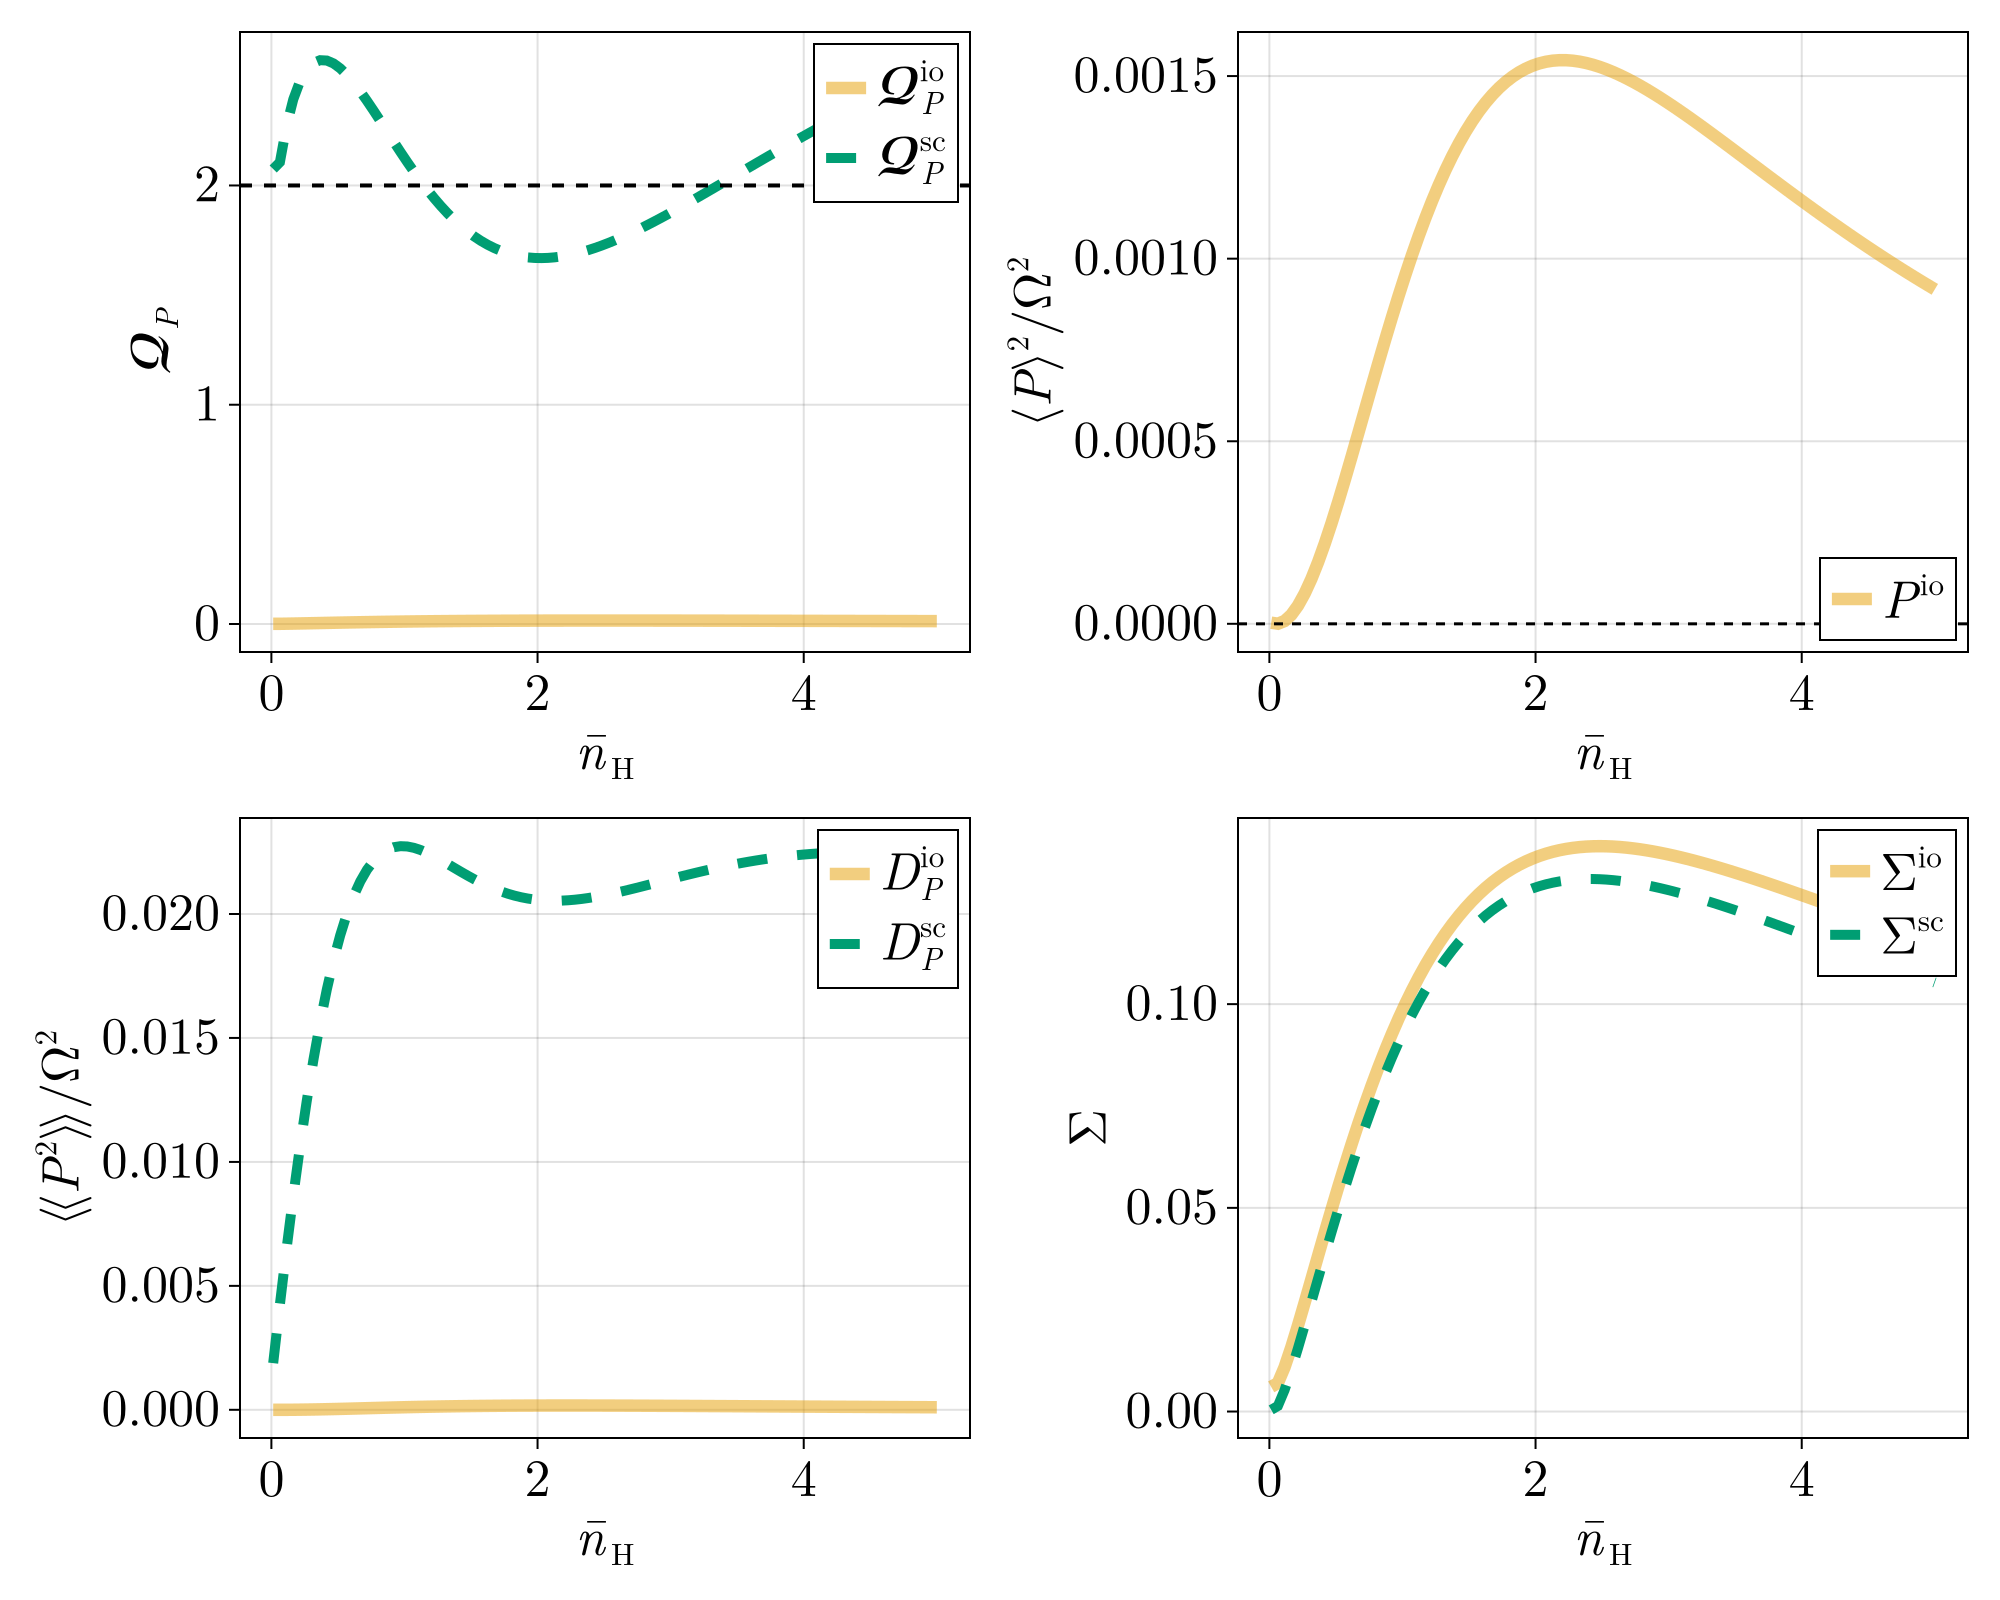

In [ ]:
qtlm_power_analysis = with_theme(theme_latexfonts()) do
    lw = 5
    lw_thick = 1.25*lw
    alpha = 0.5
    
    # Layout with 2x2 grid
    f = Figure(fontsize = 26, size = (1000, 800))
    ga = f[1,1] = GridLayout()  # Q_P comparison
    gb = f[1,2] = GridLayout()  # Power P
    gc = f[2,1] = GridLayout()  # Power noise DP
    gd = f[2,2] = GridLayout()  # Entropy production Σ
    
    xscale = identity
    
    # Panel 1: Q_P comparison
    axa = Axis(ga[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = L"\mathcal{Q}_P",
        xscale = xscale)
    # lines!(axa, the_range, 𝒬P, linewidth = lw_thick, label = L"\mathcal{Q}_P", color = Cycled(1), alpha = alpha)
    lines!(axa, the_range, 𝒬Pio, linewidth = lw_thick, label = L"\mathcal{Q}_P^\text{io}", color = Cycled(2), alpha = alpha)
    lines!(axa, the_range, 𝒬P_sc, linewidth = lw, label = L"\mathcal{Q}_P^\text{sc}", linestyle = :dash, color = Cycled(3))
    hlines!(axa, 2, color = :black, linestyle = :dash, linewidth = 2.0)
    axislegend(axa, position = (1,1))
    axa.xgridvisible = true
    
    # Panel 2: Power P
    axb = Axis(gb[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = L"\langle P \rangle^2/\Omega^2",
        xscale = xscale)
    # lines!(axb, the_range, P_n.^2/Ω^2, linewidth = lw_thick, label = L"P", color = Cycled(1), alpha = alpha)
    lines!(axb, the_range, Pio_n.^2/Ω^2, linewidth = lw_thick, label = L"P^\text{io}", color = Cycled(2), alpha = alpha)
    # lines!(axb, the_range,  P_sc_n.^2/Ω^2, linewidth = lw, label = L"P^\text{sc}", linestyle = :dash, color = Cycled(3))
    hlines!(axb, 0, color = :black, linestyle = :dash)
    axislegend(axb, position = (1,0))
    axb.xgridvisible = true
    
    # Panel 3: Power noise DP
    axc = Axis(gc[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = L"\langle\!\langle P^2 \rangle\!\rangle/\Omega^2",
        xscale = xscale)
    # lines!(axc, the_range, DP_n/Ω^2, linewidth = lw_thick, label = L"D_P", color = Cycled(1), alpha = alpha)
    lines!(axc, the_range, DP_io_n/Ω.^2, linewidth = lw_thick, label = L"D_P^\text{io}", color = Cycled(2), alpha = alpha)
    lines!(axc, the_range, DP_sc_n/Ω.^2, linewidth = lw, label = L"D_P^\text{sc}", linestyle = :dash, color = Cycled(3))
    axislegend(axc, position = (1,1))
    axc.xgridvisible = true
    
    # Panel 4: Entropy production Σ
    axd = Axis(gd[1,1], xlabel = L"\bar{n}_\text{H}", ylabel = L"\Sigma",
        xscale = xscale)
    # lines!(axd, the_range, Σ_n, linewidth = lw_thick, label = L"\Sigma", color = Cycled(1), alpha = alpha)
    lines!(axd, the_range, Σio_n, linewidth = lw_thick, label = L"\Sigma^\text{io}", color = Cycled(2), alpha = alpha)
    lines!(axd, the_range, Σ_sc_n, linewidth = lw, label = L"\Sigma^\text{sc}", linestyle = :dash, color = Cycled(3))
    axislegend(axd, position = (1,1))
    axd.xgridvisible = true
    
    current_figure()
    f
end

## Varying $g/\kappa$

In [8]:
# g range
g_range = range(0.01, stop=0.25, length=50)

# Preallocate arrays with _g suffix
JH_g = similar(g_range)
JC_g = similar(g_range)
P_sc_g = similar(g_range)
JC_sc_g = similar(g_range)
JH_sc_g = similar(g_range)
Jcav_g = similar(g_range)
Jcavio_g = similar(g_range)

P_g = similar(g_range)
Pio_g = similar(g_range)

# Noise
DC_g = similar(g_range)
DH_g = similar(g_range)
Dcav_g = similar(g_range)
DP_sc_g = similar(g_range)
DP_g = similar(g_range)
DPio_g = similar(g_range)

Σ_g = similar(g_range)
Σio_g = similar(g_range)
Σ_sc_g = similar(g_range)

# Fixed nH value
nH_fixed = 2.0
TH_fixed = nBtoTω(nH_fixed) * ω3

# Fixed other thermal parameters
nCp = nB(ω3 - Ω, TC)
ncavp = nB(Ω, Tcav)

for j=1:length(g_range)
    g_val = g_range[j]
    # Use fixed nH value
    rates = [√γH*√(nH_fixed + 1), √γC*√(nCp + 1), √κ*√(ncavp + 1), √γH*√nH_fixed, √γC*√nCp, √κ*√ncavp]
    
    # Exact model
    H, J = liouvQTLM(Δ, g_val, ℰ, Jumps, rates)
    ρss = steadystate.iterative(H, J)
    ρss = SparseOperator(ρss)

    ρtls = ptrace(ρss, 1).data
    p1, p2, p3 = ρtls[1,1], ρtls[2,2], ρtls[3,3]
    JH = ω3 * γH * (nH_fixed*p1 - (nH_fixed + 1)*p3)
    
    a_avg = tr(a ⊗ Id_tls * ρss)
    n_avg = tr(ad*a ⊗ Id_tls * ρss)

    mJH = [J[1], J[4]]
    mJC = [J[2], J[5]]
    mJcav = [J[3], J[6]]
    
    nu = [-ω3 + Ω, ω3 - Ω]
    JC, DC = fcscumulants_recursive(H, J, mJC, 2, ρss, nu)

    Jcav = Ω * κ * (ncavp - n_avg)
    Jcavio = Jcav + Ω * κ * abs(a_avg)^2

    P_g[j] = real(-ℰ * Ω * ((conj(a_avg) + a_avg)))
    Pio_g[j] = real(-ℰ * Ω * ((conj(a_avg) + a_avg)) - Ω * κ * abs(a_avg)^2)
    
    Jcavio_g[j] = real(Jcavio)
    Jcav_g[j] = real(Jcav)
    JC_g[j] = real(JC)
    JH_g[j] = real(JH)

    δP = delta_power(a_avg)
    δPio = delta_power_io(a_avg)
    Pnoise = noise_drazin(δP⊗Id_tls, H, J, ρss)
    Pionoise = noise_drazin(δPio⊗Id_tls, H, J, ρss)

    DP_g[j] = real(Pnoise)
    DPio_g[j] = real(Pionoise)
    DC_g[j] = real(DC)

    Σ_g[j] = real(-JH/TH_fixed - JC/TC - Jcav/Tcav)
    Σio_g[j] = real(-JH/TH_fixed - JC/TC - Jcavio/Tcav)

    # Semiclassical model
    rates_sc = [√γH*√(nH_fixed + 1), √γC*√(nCp + 1), √γH*√nH_fixed, √γC*√nCp]
    ℰpp = -2g_val * ℰ / κ    
    H_sc, J_sc = liouv_semiclassical(Δ, ℰpp, rates_sc)
    ρss_sc = steadystate.eigenvector(H_sc, J_sc)
    ρss_sc = SparseOperator(ρss_sc)
    mJC_sc = [J_sc[2], J_sc[4]]

    I_sc, DI_sc = fcscumulants_recursive(H_sc, J_sc, mJC_sc, 2, ρss_sc, [-1, 1])
    P_sc = Ω * I_sc
    DP_sc = Ω^2 * DI_sc

    Σ_sc = -P_sc * log(nH_fixed * (nCp + 1) / ((nH_fixed + 1) * nCp))/Ω

    P_sc_g[j] = real(P_sc)
    JC_sc_g[j] = (ω3 - Ω) * real(I_sc)
    JH_sc_g[j] = -(ω3) * real(I_sc)
    DP_sc_g[j] = real(DP_sc)
    Σ_sc_g[j] = real(Σ_sc)
end

# Calculate derived quantities
SNRC_g = @. DC_g / JC_g^2
SNRP_sc_g = @. DP_sc_g / (P_sc_g^2)
SNRP_g = @. DP_g / (P_g^2)
SNRPio_g = @. DPio_g / (Pio_g^2)

𝒬C_g = @. SNRC_g * Σ_g
𝒬Cio_g = @. SNRC_g * Σio_g
𝒬P_sc_g = @. SNRP_sc_g * Σ_sc_g

50-element Vector{Float64}:
 2.618236483136175
 2.1177832421228886
 1.8062210585283338
 1.6891165534426316
 1.7058359323765566
 1.7951791400599666
 1.9152225042657858
 2.041972006695967
 2.1633515937821666
 2.2741528747994733
 ⋮
 3.1040222465633174
 3.1078695841747166
 3.1114727240589812
 3.114851715345239
 3.1180246102159317
 3.121007695601536
 3.1238156944294353
 3.1264619408673675
 3.128958533289658

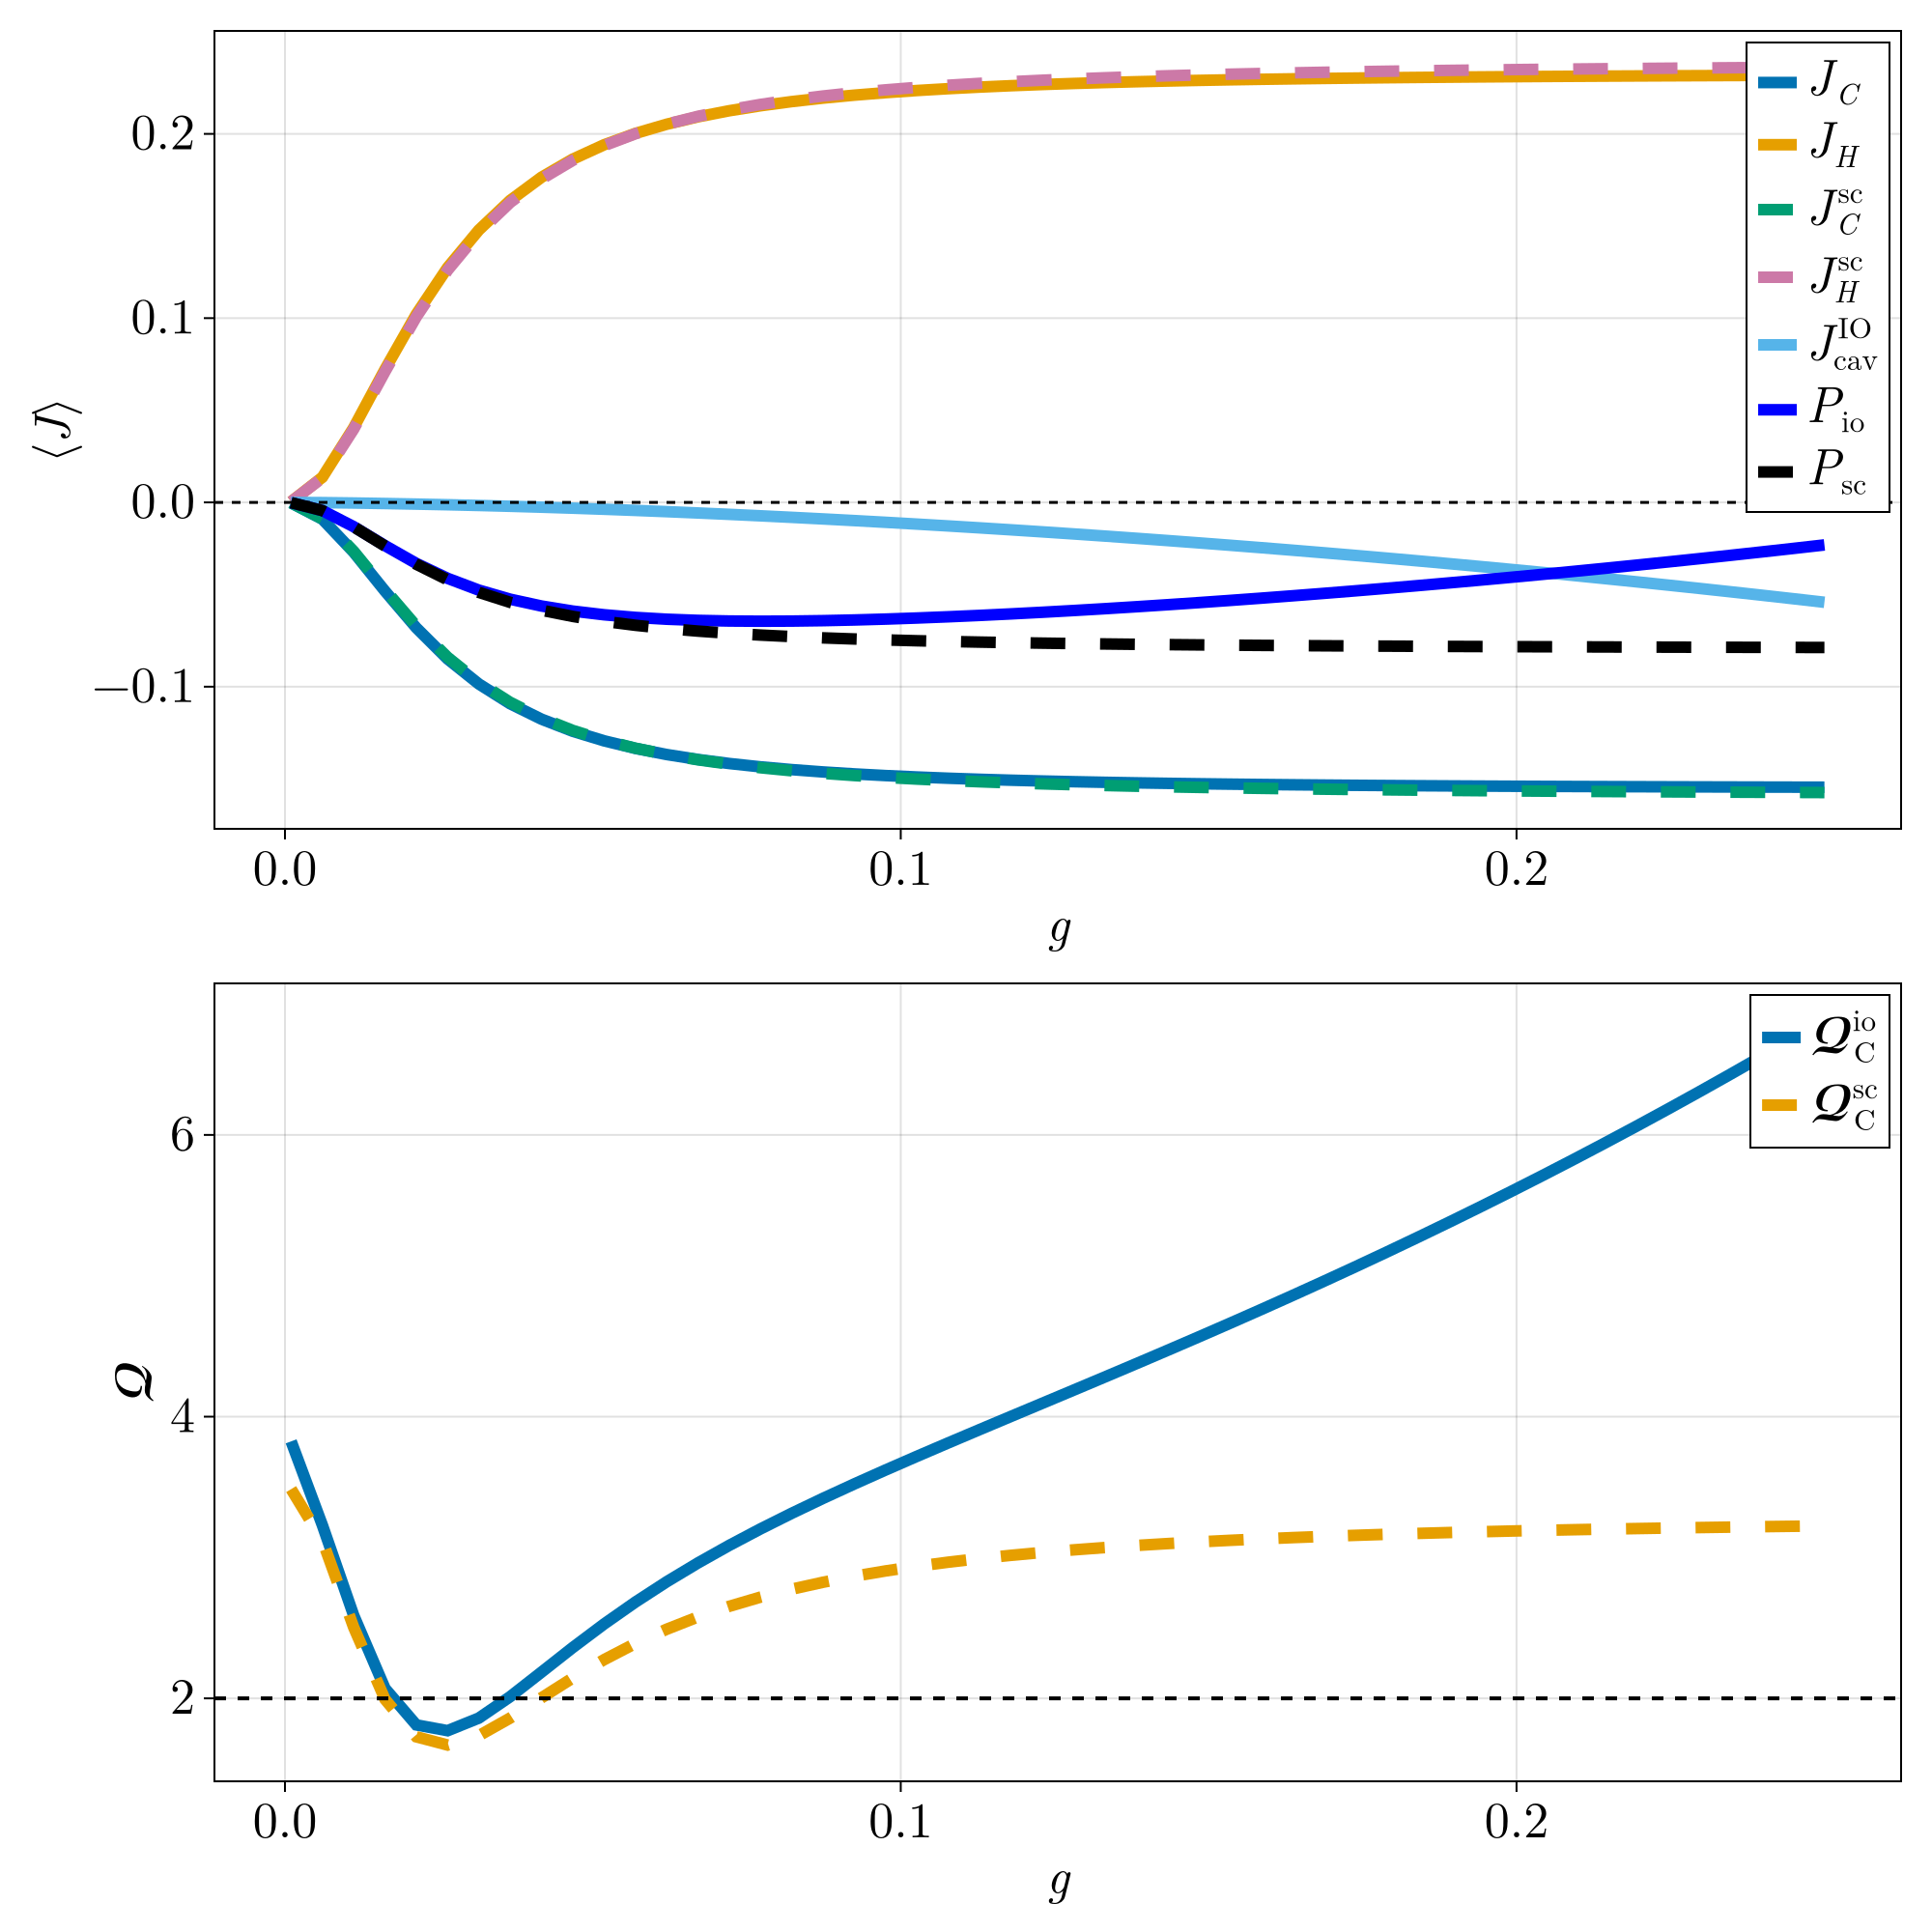

In [ ]:
qtlm_plots_g = with_theme(theme_latexfonts()) do
    lw=6
        #|=== === === === Layout
            f = Figure(fontsize = 26, size = (1000, 1000))
            c_P = :blue
            c_J = :red
            ga = f[1,1] = GridLayout()
            gd = f[2,1] = GridLayout()

            # xscale = log10
            xscale = identity

            # yscale = identity
            yscale = Makie.pseudolog10

            # #|=== === ===  Fig. (a)
            axa = Axis(ga[1,1], xscale = xscale, ylabel = L"\langle J \rangle", xlabel =L"g")
            lines!(axa, g_range, JC_g/Ω, linewidth = lw, label = L"J_C")
            lines!(axa, g_range, JH_g/Ω, linewidth = lw, label = L"J_H")
            lines!(axa, g_range, JC_sc_g/Ω, linewidth = lw, label = L"J_C^\text{sc}", linestyle = :dash)
            lines!(axa, g_range, JH_sc_g/Ω, linewidth = lw, label = L"J_H^\text{sc}", linestyle = :dash)
            lines!(axa, g_range, Jcavio_g/Ω, linewidth = lw, label = L"J_\text{cav}^\text{IO}" )
            lines!(axa, g_range, Pio_g/Ω, linewidth = lw, color = c_P, label = L"P_\text{io}")
            lines!(axa, g_range, P_sc_g/Ω, linewidth = lw, color = :black, label = L"P_\text{sc}", linestyle = :dash)
            hlines!(axa, 0, color = :black, linestyle = :dash)
            axislegend(axa, position= (1,1))

        axd = Axis(gd[1,1], xlabel = L"g", ylabel = L"\mathcal{Q}",
            xscale = xscale)
        # lines!(axd, g_range, 𝒬C_g, linewidth = lw, label = L"\mathcal{Q}_\text{C}")
        lines!(axd, g_range, 𝒬Cio_g, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{io}")
        lines!(axd, g_range, 𝒬P_sc_g, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{sc}", linestyle = :dash)
        hlines!(axd, 2, color = :black, linestyle = :dash, linewidth = 2.0)
        axislegend(axd, position = (1,1))

        current_figure()
        f
    end


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/jano/.julia/packages/Makie/TOy8O/src/scenes.jl:264


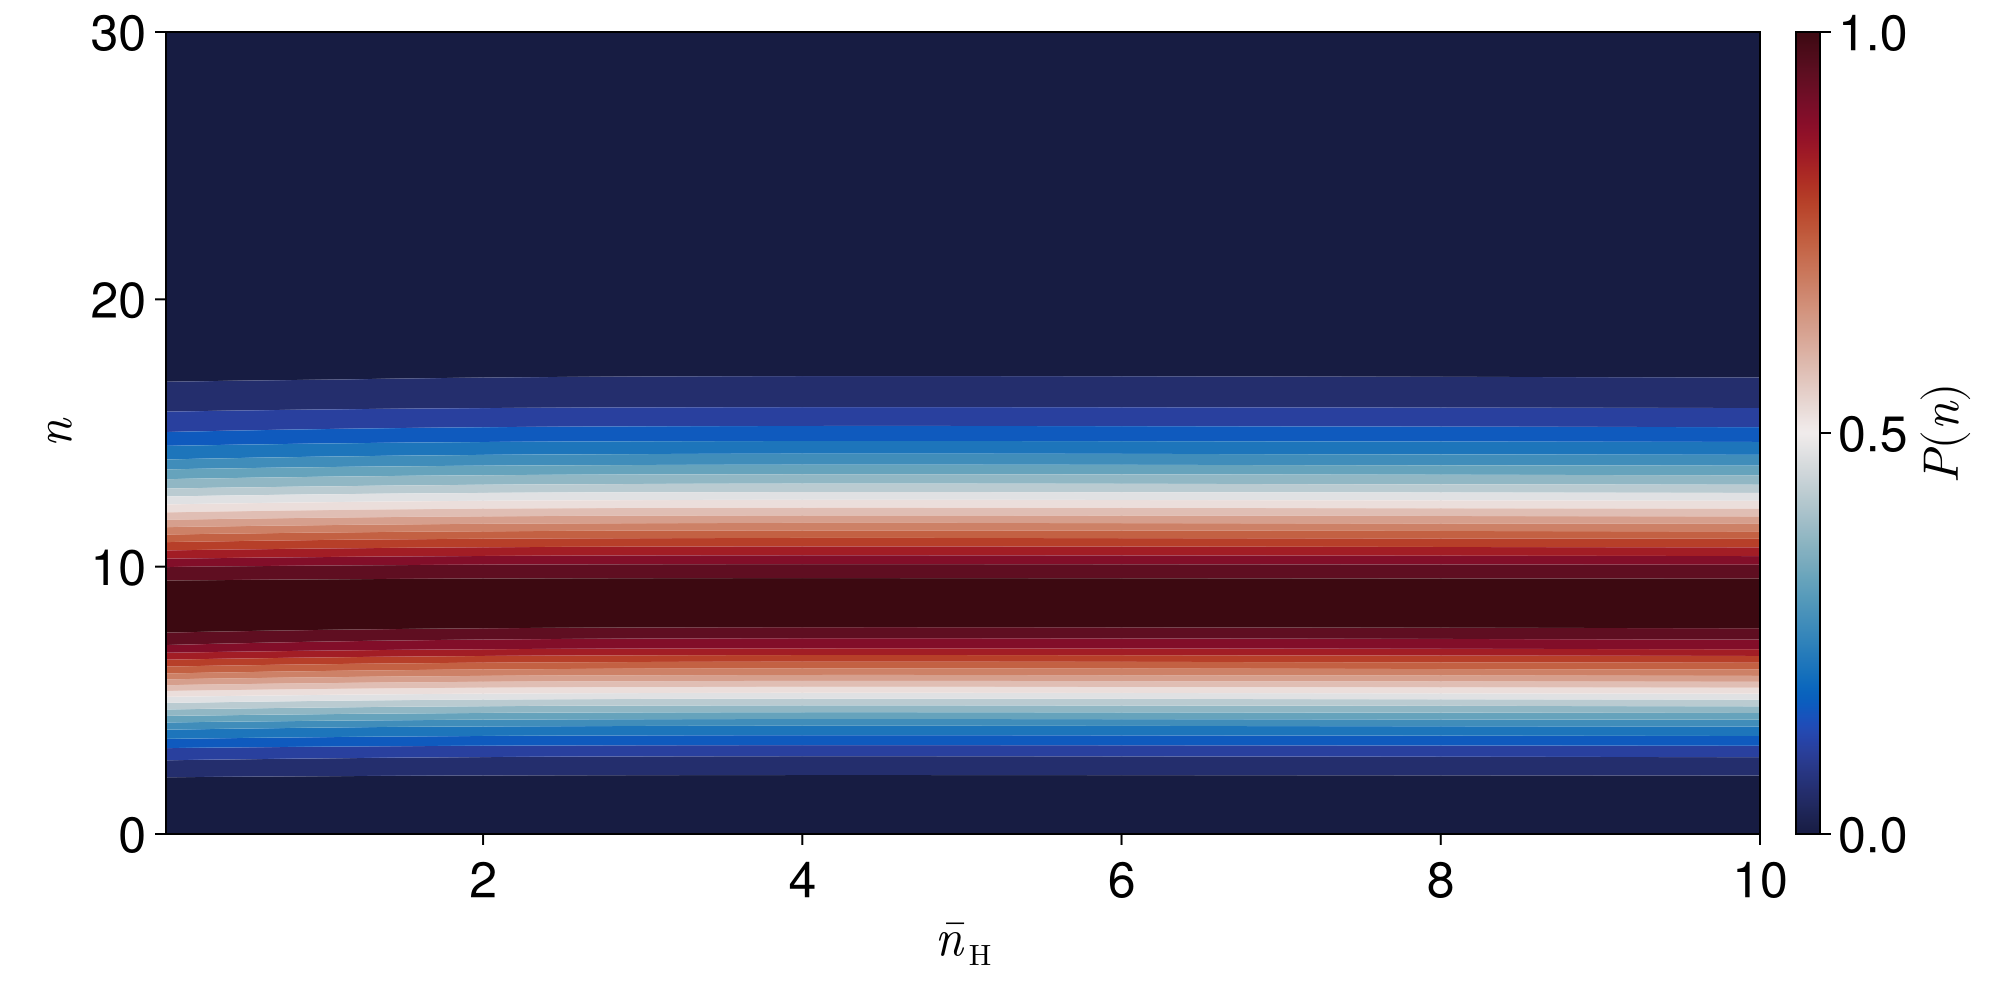

In [56]:
# Create a contour plot
fig = Figure(; linewidth = 4, fontsize = 25, resolution = (1000, 500))
ax = Axis(fig[1, 1], xlabel = L"\bar{n}_\text{H}", ylabel = L"n")
# Create contour plot
contourf!(ax, nHrange, 0:N, P_matrix, colormap = :balance, levels = 20)
Colorbar(fig[1, 2], colormap = :balance, label = L"P(n)")
fig

## Varying the $\mathcal{E}$ (f). Unpublished

In [89]:
# Sweep the drive amplitude f while keeping other parameters fixed
g = 0.05
Δ = 0.0
frange = range(0.0001, stop=1.5, length=50)

JH_f   = similar(frange)
JC_f   = similar(frange)
Jcav_f = similar(frange)
Jcavio_f = similar(frange)
P_f    = similar(frange)
Pio_f  = similar(frange)

DC_f   = similar(frange)
Dcav_f = similar(frange)
Σ_f    = similar(frange)
Σio_f  = similar(frange)


# Fixed nH value
nH_fixed = 5.0
TH_fixed = nBtoTω(nH_fixed) * ω3
# Semiclassical quantities
P_sc_f    = similar(frange)
JC_sc_f   = similar(frange)
JH_sc_f   = similar(frange)
DP_sc_f   = similar(frange)
P_sc_f    = similar(frange)
Σ_sc_f    = similar(frange)
𝒬C_sc_f   = similar(frange)
# Fixed other thermal parameters
nCp = nB(ω3 - Ω, TC)
ncavp = nB(Ω, Tcav)


for j in eachindex(frange)
    f_val = frange[j]
    ℰ = √κ * f_val

    rates = [√γH*√(nH_fixed + 1), √γC*√(nCp + 1), √κ*√(ncavp + 1),
             √γH*√nH_fixed,      √γC*√nCp,      √κ*√ncavp]

    H, J = liouvQTLM(Δ, g, ℰ, Jumps, rates)
    ρss = SparseOperator(steadystate.iterative(H, J))

    ρtls = ptrace(ρss, 1).data
    p1, p2, p3 = ρtls[1,1], ρtls[2,2], ρtls[3,3]
    JH = ω3 * γH * (nH_fixed * p1 - (nH_fixed + 1) * p3)

    mJC   = [J[2], J[5]]
    mJcav = [J[3], J[6]]

    JC, DC = fcscumulants_recursive(H, J, mJC, 2, ρss, [-(ω3 - Ω), ω3 - Ω])
    Dcav   = fcscumulants_recursive(H, J, mJcav, 2, ρss, [-Ω, Ω])[2]

    a_avg = tr(a ⊗ Id_tls * ρss)
    n_avg = tr(ad * a ⊗ Id_tls * ρss)
    Jcav = Ω * κ * (ncavp - n_avg)
    Jcavio = Jcav + Ω * κ * abs(a_avg)^2

    P_f[j]   = real(-ℰ * Ω * (conj(a_avg) + a_avg))
    Pio_f[j] = real(P_f[j] - Ω * κ * abs(a_avg)^2)

    JH_f[j]     = real(JH)
    JC_f[j]     = real(JC)
    Jcav_f[j]   = real(Jcav)
    Jcavio_f[j] = real(Jcavio)

    DC_f[j]   = real(DC)
    Dcav_f[j] = real(Dcav)

    Σ_f[j]   = real(-JH/TH - JC/TC - Jcav/Tcav)
    Σio_f[j] = real(-JH/TH - JC/TC - Jcavio/Tcav)

    # Semiclassical model
    rates_sc = [√γH*√(nH_fixed + 1), √γC*√(nCp + 1), √γH*√nH_fixed, √γC*√nCp]
    ℰp = -2g * ℰ / κ    
    H_sc, J_sc =  liouv_semiclassical(Δ, ℰp, rates_sc)
    ρss_sc = steadystate.eigenvector(H_sc, J_sc)
    ρss_sc = SparseOperator(ρss_sc)
    mJC_sc= [J_sc[2], J_sc[4]]

    I_sc, DI_sc = fcscumulants_recursive(H_sc, J_sc, mJC_sc, 2, ρss_sc, [-1, 1])
    # I_sc = fcscumulants_recursive(H_sc, J_sc, mJC_sc, 1, ρss_sc; nu = [-1, 1])[1]
    P_sc = Ω * I_sc
    DP_sc = Ω^2 * DI_sc

    # F_sc = abs(DP_sc/P_sc)/Ω
    Σ_sc =   -P_sc * log(nH_fixed * (nCp + 1) / ((nH_fixed + 1) * nCp))/Ω
    
    P_sc_f[j]    = P_sc
    DP_sc_f[j]   = DP_sc
    Σ_sc_f[j]    = Σ_sc
end

SNRC_f   = @. DC_f / JC_f^2
𝒬C_f    = @. SNRC_f * Σ_f
𝒬Cio_f  = @. SNRC_f * Σio_f
𝒬C_sc_f = @. (DP_sc_f / P_sc_f^2) * Σ_sc_f


50-element Vector{Float64}:
 3.6795960209123755
 3.676767510504765
 3.668360036738188
 3.654439187221841
 3.6351225586419202
 3.6105720687292964
 3.580991388207664
 3.546622757697449
 3.5077432712329024
 3.4646607194483354
 ⋮
 1.809455855507625
 1.785897082054108
 1.7645175844423744
 1.7452520753746037
 1.7280311277815141
 1.7127820524786108
 1.6994296981201147
 1.6878971751159475
 1.678106505997325

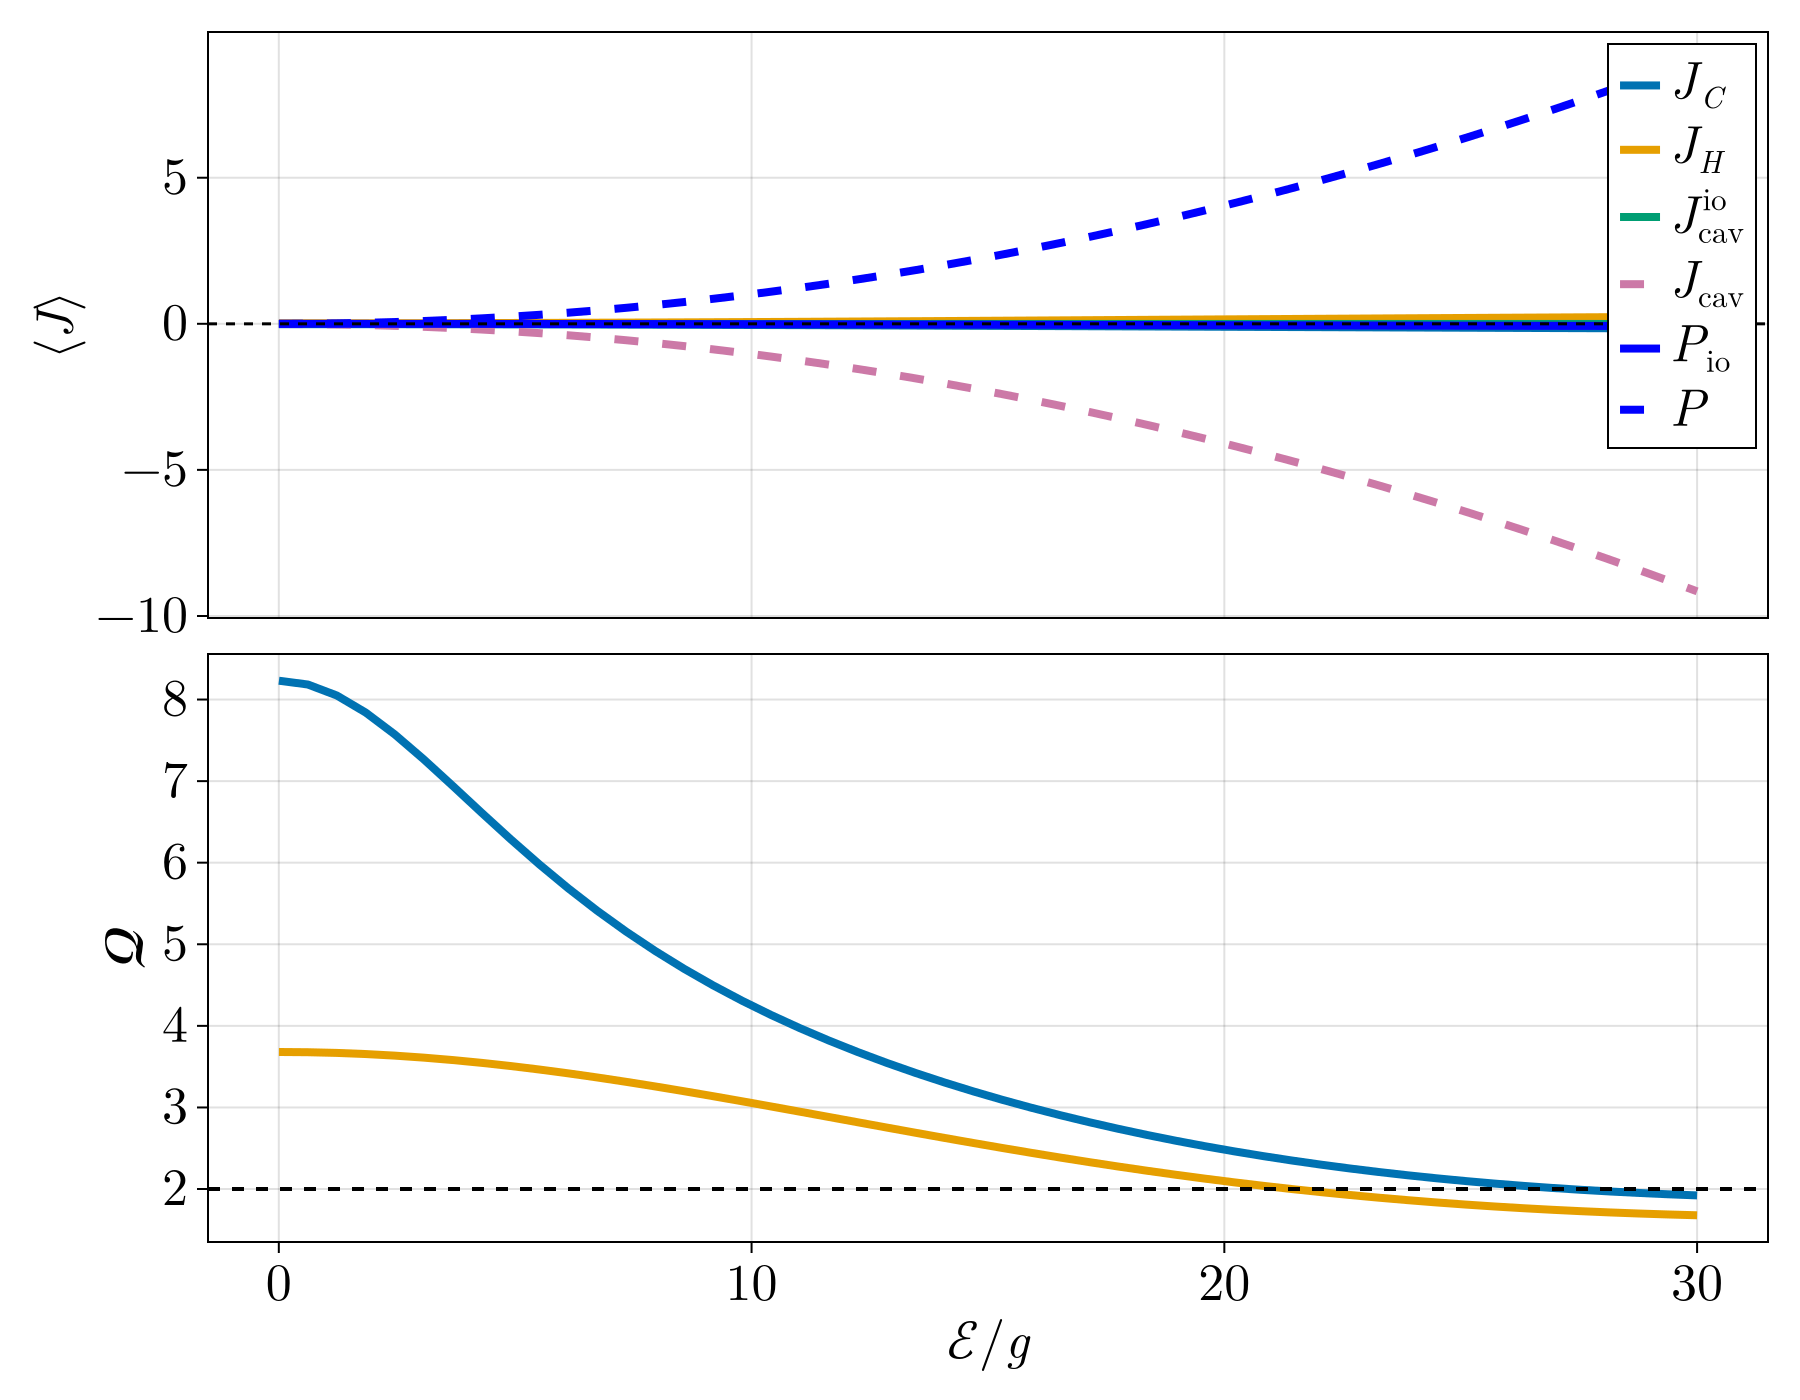

In [90]:
with_theme(theme_latexfonts()) do
    lw = 4
    ffig = Figure(fontsize = 26, size = (900, 700))
    ga = ffig[1,1] = GridLayout()
    gb = ffig[2,1] = GridLayout()

    ax1 = Axis(ga[1,1], xlabel = L"f", ylabel = L"\langle J \rangle")
    lines!(ax1, frange, JC_f/Ω, linewidth = lw, label = L"J_C")
    lines!(ax1, frange, JH_f/Ω, linewidth = lw, label = L"J_H")
    lines!(ax1, frange, Jcavio_f/Ω, linewidth = lw, label = L"J_{\text{cav}}^\text{io}")
    lines!(ax1, frange, Jcav_f/Ω, linewidth = lw, linestyle = :dash, label = L"J_{\text{cav}}")
    lines!(ax1, frange, Pio_f/Ω, linewidth = lw, color = :blue, label = L"P_{\text{io}}")
    lines!(ax1, frange, P_f/Ω, linewidth = lw, color = :blue, linestyle = :dash, label = L"P")
    hlines!(ax1, 0, color = :black, linestyle = :dash)
    axislegend(ax1, position = (1,1))
    hidexdecorations!(ax1)
    ax1.xgridvisible = true

    ax2 = Axis(gb[1,1], xlabel = L"ℰ/g", ylabel = L"\mathcal{Q}")
    # lines!(ax2, frange, 𝒬C_f, linewidth = lw, label = L"\mathcal{Q}_\text{C}")
    lines!(ax2, frange./g, 𝒬Cio_f, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{io}")
    lines!(ax2, frange./g, 𝒬C_sc_f, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{sc}")
    hlines!(ax2, 2, color = :black, linestyle = :dash, linewidth = 2.0)

    ffig
end

## Adiabatic elimination. Unplished

In [122]:
g = 10/ (134 * 1.5)
f = 1.5
# f = 0.0
Δ = 0.0
γH = 0.1
# γC = 100.0
γC = 2.0
κ = 1.0
ℰ  = √κ*f
ℰp  =  -2g*ℰ/κ

TH = 1e9
Tcav= 2000.0
# Tcav = 100.0
TC = Tcav * 2.75
# TC = TH

Ω = ω2 = 10000.0
ω3 = 3*ω2

nC = nB(ω3-Ω,TC)
ncav = nB(Ω,Tcav)
# nH = 5.0 
nH = nB(ω3,TH)
;
println("g = $g, f = $f, ℰ = $ℰ, ℰp = $ℰp")

g = 0.04975124378109453, f = 1.5, ℰ = 1.5, ℰp = -0.1492537313432836


In [123]:
ncav_range = range(ncav, stop=2.0, length=100);
# Create inverse of nB function to calculate temperature from occupation number
Tb(n, ω) = ω/log(1 + 1/n);
Tcav_range = Tb.(ncav_range, (Ω,))
TC = 130000.0
Jcav_ncav = similar(ncav_range)
Dcav_ncav = similar(ncav_range)
Jcav_adb_ncav = similar(ncav_range)
Dcav_adb_ncav = similar(ncav_range)

for j=1:length(ncav_range)
    
    nHp = nB(ω3, Trange[j])
    nC = nB(ω3 - Ω, TC)
    ncavp = ncav_range[j]

    rates = [√γH*√(nH + 1), √γC√(nC + 1), √κ√(ncavp + 1), √γH*√nH, √γC*√nC, √κ*√ncavp]
    H, J =  liouvQTLM(Δ, g, ℰ, Jumps, rates)
    ρss = steadystate.iterative(H, J)
    ρss = SparseOperator(ρss)

    a_avg = tr(a⊗Id_tls*ρss)
    mJcav = [J[3], J[6]]
    
    nu = [-1, 1]
    Jcav, Dcav = fcscumulants_recursive(H, J, mJcav, 2, ρss,nu)

    Jcav_ncav[j] = real(Jcav)
    Dcav_ncav[j] = real(Dcav)

    # Adiabatic elimination
    H_adb, J_adb =  liouvQTLM_adb(Δ, g, ℰ, rates)
    ρss_adb = steadystate.iterative(H_adb, J_adb)
    ρss_adb = SparseOperator(ρss_adb)
    mJcav_adb = [J_adb[3], J_adb[6]]
    
    nu = [-1, 1]
    Jcav_adb, Dcav_adb = fcscumulants_recursive(H_adb, J_adb, mJcav_adb, 2, ρss_adb,nu)

    Jcav_adb_ncav[j] = real(Jcav_adb)
    Dcav_adb_ncav[j] = real(Dcav_adb)
    
    
end

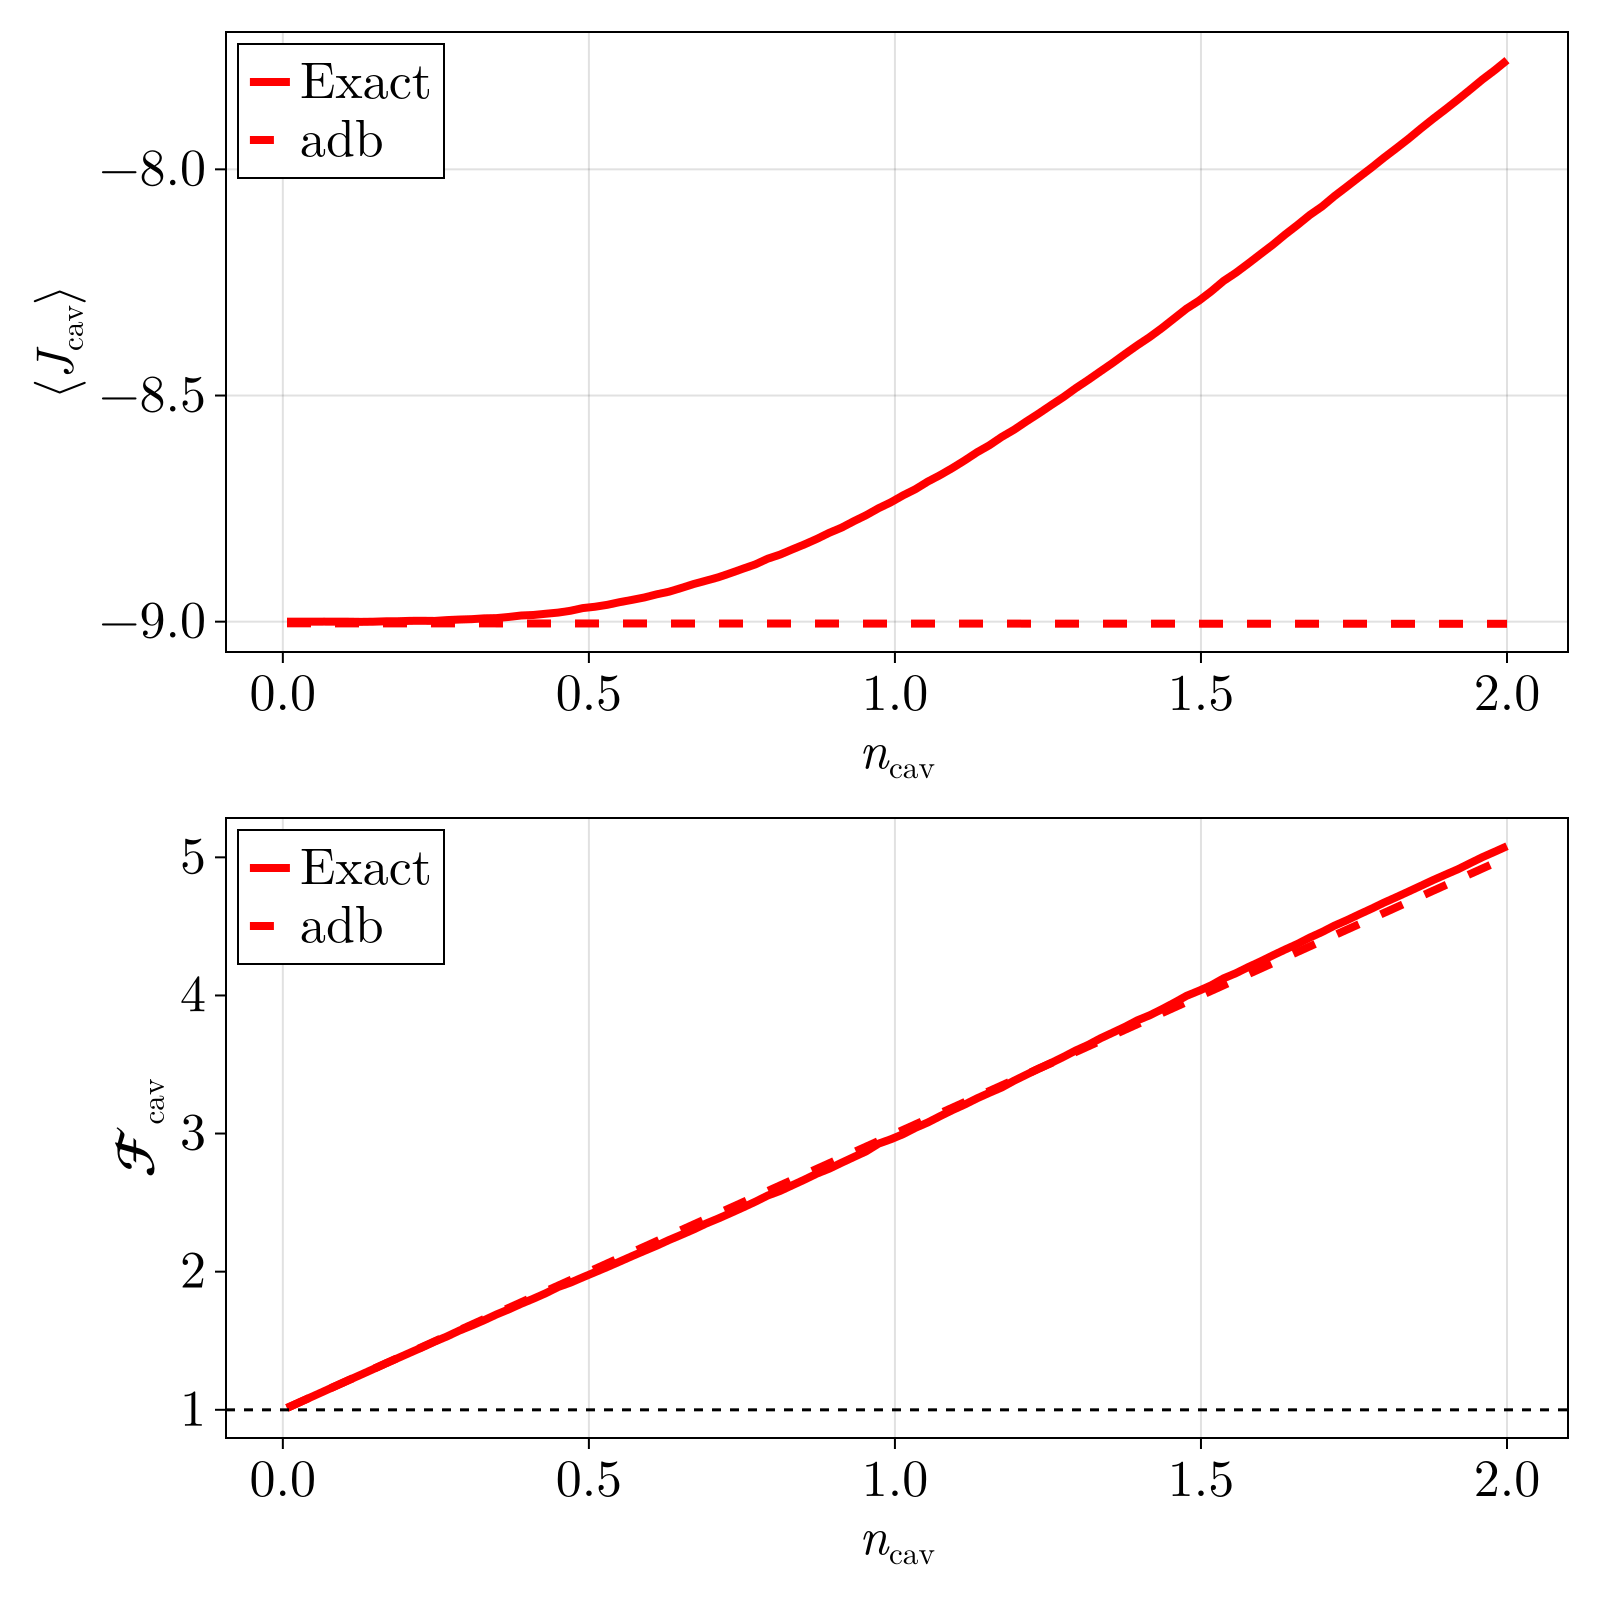

In [124]:
# Compute Fano factors
Fcav_ncav = @. abs(Dcav_ncav / Jcav_ncav)
Fcav_adb_ncav = @. abs(Dcav_adb_ncav / Jcav_adb_ncav)

# Create comparison plots
adiabatic_comparison = with_theme(theme_latexfonts()) do
    lw = 4
    f = Figure(fontsize = 26, size = (800, 800))
    
    # Top panel: Compare currents
    ga = f[1,1] = GridLayout()
    axa = Axis(ga[1,1], xlabel = L"n_\text{cav}", ylabel = L"\langle J_\text{cav} \rangle")
    lines!(axa, ncav_range, Jcav_ncav, linewidth = lw, color = :red, label = "Exact")
    lines!(axa, ncav_range, Jcav_adb_ncav, linewidth = lw, color = :red, linestyle = :dash, 
           label = "adb")
    axislegend(axa, position = (0,1))
    axa.xgridvisible = true
    
    # Bottom panel: Compare Fano factors
    gb = f[2,1] = GridLayout()
    axb = Axis(gb[1,1], xlabel = L"n_\text{cav}", ylabel = L"\mathcal{F}_\text{cav}")
    lines!(axb, ncav_range, Fcav_ncav, linewidth = lw, color = :red, label = "Exact")
    lines!(axb, ncav_range, Fcav_adb_ncav, linewidth = lw, color = :red, linestyle = :dash, 
           label = "adb")
    hlines!(axb, 1, color = :black, linestyle = :dash)
    axislegend(axb, position = (0,1))
    axb.ygridvisible = false
    
    f
end

In [15]:
nH_range = range(ncav, stop=2.0, length=100);
# Create inverse of nB function to calculate temperature from occupation number
Tb(n, ω) = ω/log(1 + 1/n);
Tcav_range = Tb.(ncav_range, (Ω,))
TC = 130000.0
Jcav_ncav = similar(ncav_range)
Dcav_ncav = similar(ncav_range)
Jcav_adb_ncav = similar(ncav_range)
Dcav_adb_ncav = similar(ncav_range)

for j=1:length(ncav_range)
    
    nHp = nB(ω3, Trange[j])
    nC = nB(ω3 - Ω, TC)
    ncavp = ncav_range[j]

    rates = [√γH*√(nH + 1), √γC√(nC + 1), √κ√(ncavp + 1), √γH*√nH, √γC*√nC, √κ*√ncavp]
    H, J =  liouvQTLM(Δ, g, ℰ, Jumps, rates)
    ρss = steadystate.iterative(H, J)
    ρss = SparseOperator(ρss)

    a_avg = tr(a⊗Id_tls*ρss)
    mJcav = [J[3], J[6]]
    
    nu = [-1, 1]
    Jcav, Dcav = fcscumulants_recursive(H, J, mJcav, 2, ρss,nu)

    Jcav_ncav[j] = real(Jcav)
    Dcav_ncav[j] = real(Dcav)

    # Adiabatic elimination
    H_adb, J_adb =  liouvQTLM_adb(Δ, g, ℰ, rates)
    ρss_adb = steadystate.iterative(H_adb, J_adb)
    ρss_adb = SparseOperator(ρss_adb)
    mJcav_adb = [J_adb[3], J_adb[6]]
    
    nu = [-1, 1]
    Jcav_adb, Dcav_adb = fcscumulants_recursive(H_adb, J_adb, mJcav_adb, 2, ρss_adb,nu)

    Jcav_adb_ncav[j] = real(Jcav_adb)
    Dcav_adb_ncav[j] = real(Dcav_adb)
     
end

UndefVarError: UndefVarError: `ncav_range` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
Pio_n
# Find the index and value of the minimum of Pio_n
min_idx = findmin(Pio_n)[2]  # Get the index of the minimum value
min_value = Pio_n[min_idx]   # Get the minimum value itself
Tmin = Trange[min_idx]           # Get the corresponding temperature

println("Minimum value of Pio_n: $(min_value)")
println("Found at index: $(min_idx)")
println("Corresponding temperature: $(Tmin)")

In [16]:
# Define a range of g values from 0 to 5
g_range = range(0, stop=10.0, length=100)

# Use existing parameters
Δ = 0.0
γ = 0.3
f = 0.001
γH = γ
γC = γ
κ = 100.0
ϵ = √κ*f
# TH = 1e7
# TC = Tcav  # Use the existing Tcav value
TC = 0
TH = 0
Tcav = 0
# Initialize arrays for results
Jcav_g = similar(g_range)
Dcav_g = similar(g_range)
Jcav_adb_g = similar(g_range)
Dcav_adb_g = similar(g_range)

g20 = similar(g_range)
g20_adb = similar(g_range)

# Calculate for each g value
for j in 1:length(g_range)
    g_val = g_range[j]
    
    # nHp = nB(ω3, TH)
    # nCp = nB(ω3 - Ω, TC)
    # ncavp = ncav  # Use fixed ncav value
    
    nHp = 0.000001
    nCp = 0.0000001
    ncavp = 0.000001

    rates = [√γH*√(nHp + 1), √γC*√(nCp + 1), √κ*√(ncavp + 1), √γH*√nHp, √γC*√nCp, √κ*√ncavp]
    
    # Exact model
    H, J = liouvQTLM(Δ, g_val, ϵ, Jumps, rates)
    ρss = steadystate.iterative(H, J)
    ρss = SparseOperator(ρss)
    ρ0 = (a⊗ Id_tls) * ρss * (ad⊗ Id_tls)
    ρ0 = ρ0/tr(ρ0)

    g20[j]= real(tr(ad*a ⊗ Id_tls * ρ0)/tr(ad*a ⊗ Id_tls*ρss)^2)
    
    mJcav = [J[3], J[6]]
    nu = [-1, 1]
    Jcav, Dcav = fcscumulants_recursive(H, J, mJcav, 2, ρss,nu)
    
    Jcav_g[j] = real(Jcav)
    Dcav_g[j] = real(Dcav)
    
    # Adiabatic elimination\
    a_adb = adiabatic_elimination(Δ, g_val, κ, ϵ)
    ad_adb = dagger(a_adb)
    H_adb, J_adb = liouvQTLM_adb(Δ, g_val, ϵ, rates)
    ρss_adb = steadystate.iterative(H_adb, J_adb)
    ρss_adb = SparseOperator(ρss_adb)
    
    ρ0_adb = a_adb*ρss_adb*ad_adb
    ρ0_adb = ρ0_adb/tr(ρ0_adb)

    g20_adb[j] = real(tr(ad_adb*a_adb*ρ0_adb)/tr(ad_adb*a_adb*ρss_adb)^2)

    mJcav_adb = [J_adb[3], J_adb[6]]
    Jcav_adb, Dcav_adb = fcscumulants_recursive(H_adb, J_adb, mJcav_adb, 2, ρss_adb,nu)
    
    Jcav_adb_g[j] = real(Jcav_adb)
    Dcav_adb_g[j] = real(Dcav_adb)
end

# Compute Fano factors
Fcav_g = @. abs(Dcav_g / Jcav_g)
Fcav_adb_g = @. abs(Dcav_adb_g / Jcav_adb_g)
;

In [ ]:
# Create comparison plots
g_comparison = with_theme(theme_latexfonts()) do
       lw = 4
       f = Figure(fontsize = 26, size = (800, 800))

       # Top panel: Compare currents
       ga = f[1,1] = GridLayout()
       axa = Axis(ga[1,1], xlabel = L"g", ylabel = L"\langle J_\text{cav} \rangle")
       lines!(axa, g_range, Jcav_g, linewidth = lw, color = :red, label = "Exact")
       lines!(axa, g_range, Jcav_adb_g, linewidth = lw, color = :red, linestyle = :dash, 
       label = "Adiabatic")
       axislegend(axa, position = (1,0))
       axa.xgridvisible = true
       hidexdecorations!(axa)

       # Bottom panel: Compare Fano factors
       gb = f[2,1] = GridLayout()
       axb = Axis(gb[1,1], xlabel = L"g", ylabel = L"\mathcal{F}_\text{cav}")
       lines!(axb, g_range, Fcav_g, linewidth = lw, color = :red, label = "Exact")
       lines!(axb, g_range, Fcav_adb_g, linewidth = lw, color = :red, linestyle = :dash, 
       label = "Adiabatic")
       hlines!(axb, 1, color = :black, linestyle = :dash)
       # axislegend(axb, position = (0,1))
       axb.ygridvisible = true
       hidexdecorations!(axb)
       
       # Third panel: Compare g^(2)(0) values
       gc = f[3,1] = GridLayout()
       axc = Axis(gc[1,1], xlabel = L"g", ylabel = L"g^{(2)}(0)")
       lines!(axc, g_range, g20, linewidth = lw, color = :blue, label = "Exact")
       lines!(axc, g_range, g20_adb, linewidth = lw, color = :blue, linestyle = :dash, 
       label = "Adiabatic")
       hlines!(axc, 1, color = :black, linestyle = :dash)
       axc.ygridvisible = false
       f
end

# Paper plots

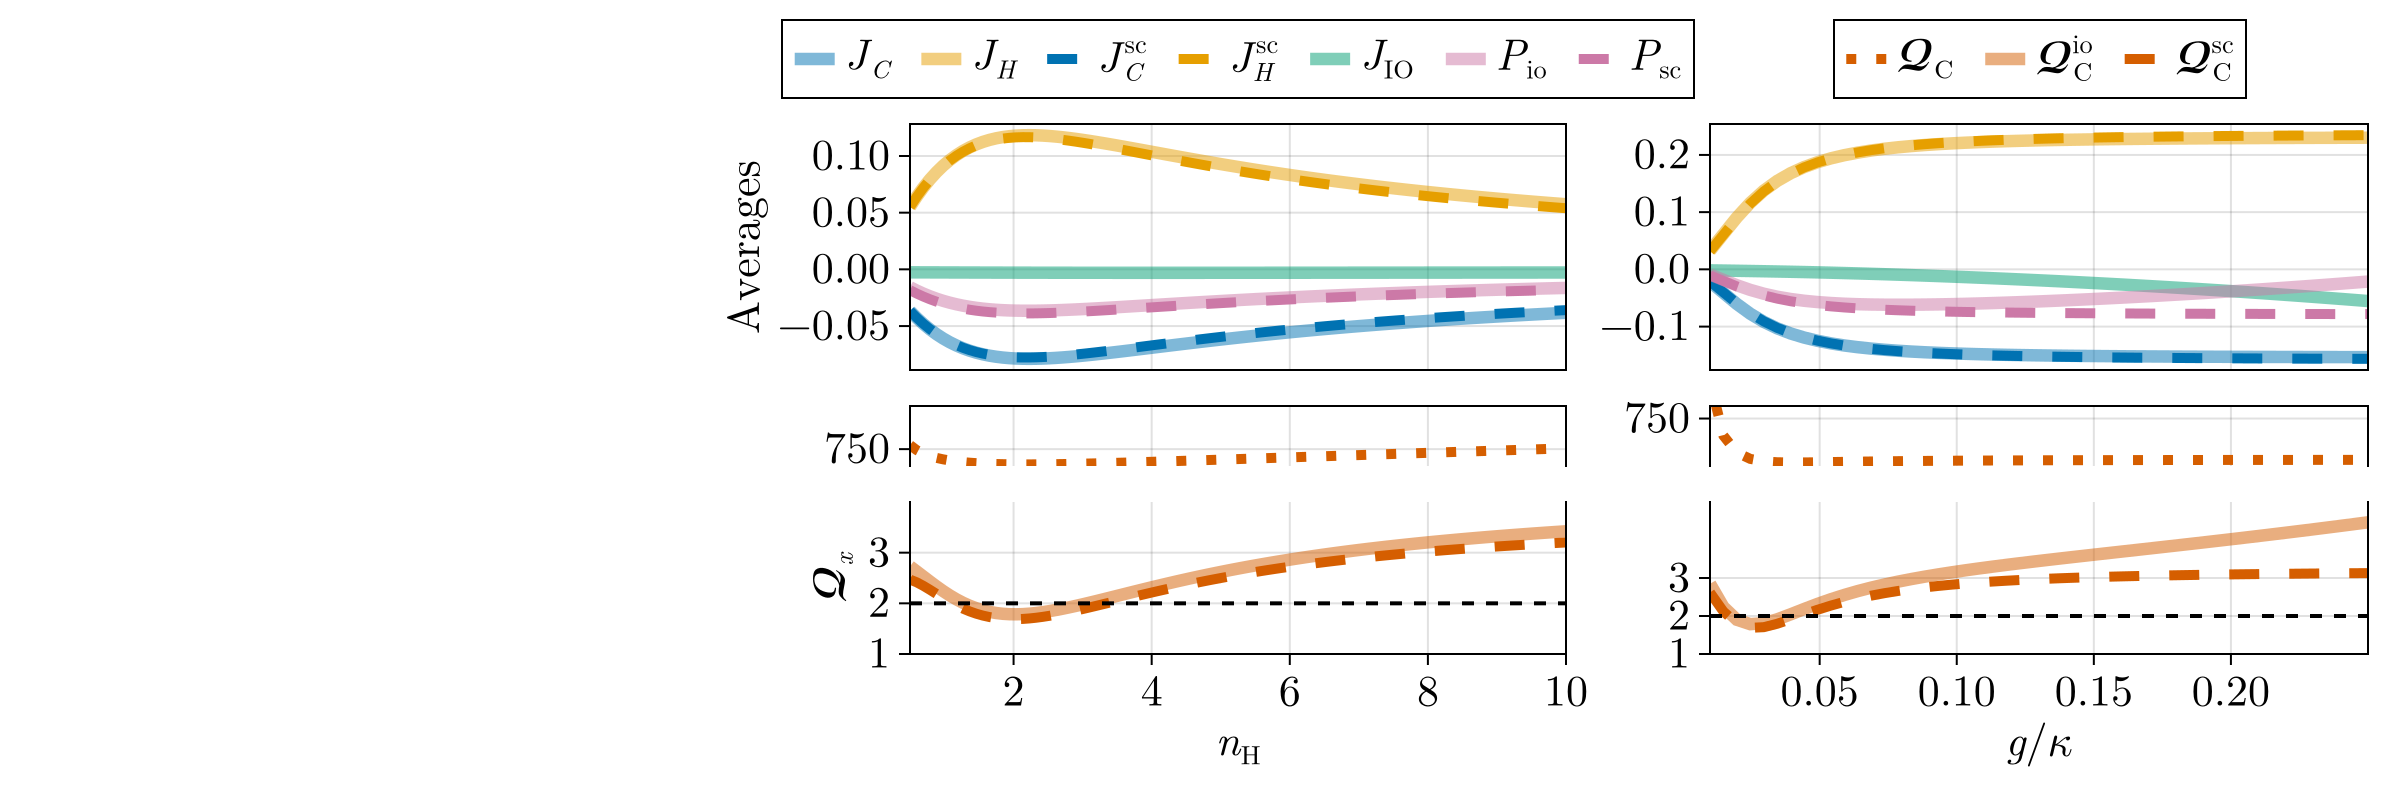

In [14]:
qtlm_plots = with_theme(theme_latexfonts()) do
    lw=5
    lw_thick = 1.25*lw
    alpha = 0.5
    #|=== === === === Layout
    f = Figure(fontsize = 22, size = (1200, 400))
    c_P = :blue
    c_J = :red
    c_Q = Cycled(5)
    # ga = f[1,2] = GridLayout()
    ga = f[2,2] = GridLayout()
    # gb = f[2,2] = GridLayout()
    gb = f[3,2] = GridLayout()
    # gc = f[1,3] = GridLayout()
    gc = f[2,3] = GridLayout()
    # gd = f[2,3] = GridLayout()
    gd = f[3,3] = GridLayout()


    # Sketch
    # ax_img = Axis(f[1:2,1])
    # xscale = log10
    xscale = identity
    yscale = identity
    # yscale = Makie.pseudolog10

    # #|=== === ===  Fig. (a)
    axa = Axis(ga[1,1], xscale = xscale, ylabel = "Averages", xlabel =L"\bar{n}_\text{H}")
    lines!(axa, the_range, JC_n/Ω, linewidth = lw_thick, label = L"J_C", color = Cycled(1), alpha = alpha)
    lines!(axa, the_range, JH_n/Ω, linewidth = lw_thick, label = L"J_H", color = Cycled(2), alpha = alpha)
    lines!(axa, the_range, JC_sc_n/Ω, linewidth = lw, label = L"J_C^\text{sc}", linestyle = :dash)
    lines!(axa, the_range, JH_sc_n/Ω, linewidth = lw, label = L"J_H^\text{sc}", linestyle = :dash)
    lines!(axa, the_range, Jcavio_n/Ω, linewidth = lw_thick, label = L"J_\text{IO}", color = Cycled(3), alpha = alpha)
    lines!(axa, the_range, Pio_n/Ω, linewidth = lw_thick, label = L"P_\text{io}", color = Cycled(4), alpha = alpha)
    lines!(axa, the_range, P_sc_n/Ω, linewidth = lw, label = L"P_\text{sc}", linestyle = :dash, color = Cycled(4))
    # lines!(axa, the_range, P_n/Ω, linewidth = lw, label = L"P", linestyle = :dot, color = Cycled(4))
    # lines!(axa, the_range, -Jcav_n/Ω, linewidth = lw, label = L"-J_\text{cav}", linestyle = :dot, color = Cycled(3))
    # hlines!(axa, 0, color = :black, linestyle = :dash)
    # axislegend(axa, position= (1, 0.75), nbanks = 4)
    xlims!(axa, minimum(the_range), maximum(the_range))

    hidexdecorations!(axa)
    axa.xgridvisible = true

    low_lims = (1, 4)
    high_lims = (minimum(𝒬C)*0.75, minimum(𝒬C)*10)

    # Create upper and lower axes
    axb_top = Axis(gb[1, 1], yticks = [750, 2500])
    axb_bottom = Axis(gb[2:3,1], xlabel = L"n_\text{H}",
     ylabel = L"\mathcal{Q}_x",
        xscale = xscale, yticks = [1, 2, 3])
    # Plot the data
    # lines!(axb_top, x_high, 𝒬C)
    # lines!(axb_bottom, the_range, 𝒬Cio)
    # lines!(axb_bottom, the_range, 𝒬P_sc)

    lines!(axb_top, the_range, 𝒬C, linewidth = lw, label = L"\mathcal{Q}_\text{C}", color = Cycled(6), linestyle = :dot)
    lines!(axb_bottom, the_range, 𝒬C, linewidth = lw, label = L"\mathcal{Q}_\text{C}", color = Cycled(6), linestyle = :dot)
    lines!(axb_bottom, the_range, 𝒬Cio, linewidth = lw_thick, label = L"\mathcal{Q}_\text{C}^\text{io}", color = Cycled(6), alpha = alpha)
    lines!(axb_bottom, the_range, 𝒬P_sc, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{sc}", linestyle = :dash, color = Cycled(6))
    hlines!(axb_bottom, 2, color = :black, linestyle = :dash, linewidth = 2.0)

    set_broken_axis!(axb_top, axb_bottom, the_range , high_lims, low_lims)
    # add_figure_break_indicators!(f, (0.384, 0.43), (0.68, 0.43))
    # add_figure_break_indicators!(f, (0.11, 0.43), (0.49, 0.43))

    # axislegend(axb_bottom, position = (1,0.1), nbanks = 2)


    # Panel for g-dependence plots
    axc = Axis(gc[1,1], xlabel = L"g/\kappa", xscale = xscale)
    lines!(axc, g_range, JC_g/Ω, linewidth = lw_thick, label = L"J_\text{C}", color = Cycled(1), alpha = alpha)
    lines!(axc, g_range, JH_g/Ω, linewidth = lw_thick, label = L"J_\text{H}", color = Cycled(2), alpha = alpha)
    lines!(axc, g_range, JC_sc_g/Ω, linewidth = lw, label = L"J_C^\text{sc}", linestyle = :dash)
    lines!(axc, g_range, JH_sc_g/Ω, linewidth = lw, label = L"J_H^\text{sc}", linestyle = :dash)
    lines!(axc, g_range, Jcavio_g/Ω, linewidth = lw_thick, label = L"J_\text{io}", color = Cycled(3), alpha = alpha)
    lines!(axc, g_range, Pio_g/Ω, linewidth = lw_thick, label = L"P_\text{io}", color = Cycled(4), alpha = alpha)
    lines!(axc, g_range, P_sc_g/Ω, linewidth = lw, label = L"P_\text{sc}", linestyle = :dash, color = Cycled(4))
    hidexdecorations!(axc)
    xlims!(axc, minimum(g_range), maximum(g_range))
    axc.xgridvisible = true

    # Q-plots for g with broken axis
    low_lims_g = (1, 5)
    high_lims_g = (minimum(𝒬C_g)*0.75, minimum(𝒬C_g)*5)

    axd_top = Axis(gd[1, 1], yticks = [750, 2000])
    axd_bottom = Axis(gd[2:3,1], xlabel = L"g/\kappa", xscale = xscale, yticks = [1, 2, 3])

    lines!(axd_top, g_range, 𝒬C_g, linewidth = lw, label = L"\mathcal{Q}_\text{C}", color = Cycled(6), linestyle = :dot)
    lines!(axd_bottom, g_range, 𝒬C_g, linewidth = lw, label = L"\mathcal{Q}_\text{C}", color = Cycled(6), linestyle = :dot)
    lines!(axd_bottom, g_range, 𝒬Cio_g, linewidth = lw_thick, label = L"\mathcal{Q}_\text{C}^\text{io}", color = Cycled(6), alpha = alpha)
    lines!(axd_bottom, g_range, 𝒬P_sc_g, linewidth = lw, label = L"\mathcal{Q}_\text{C}^\text{sc}", linestyle = :dash, color = Cycled(6))
    hlines!(axd_bottom, 2, color = :black, linestyle = :dash, linewidth = 2.0)

    set_broken_axis!(axd_top, axd_bottom, g_range, high_lims_g, low_lims_g)
    # add_figure_break_indicators!(f, (0.6, 0.43), (0.985, 0.43))
    
    # Legends
    # axislegend(axa, position= (1, 0.85), nbanks = 3, labelsize = 15)
    Legend(f[1, 2], axa, nbanks = 7, labelsize = 22, tellwidth = false, tellheight = false)
    # axislegend(axb_bottom, position = (0.95,-1.0), nbanks = 1, labelsize = 20)
    Legend(f[1, 3], axb_bottom, nbanks = 3, labelsize = 22, tellwidth = false, tellheight = false)
    
    # Adjust row heights: make first row slimmer
    f.layout.rowsizes = [Relative(0.1), Relative(0.45), Relative(0.45)]
    f
    end
        

In [15]:
save("../plots/qtlm_plots.pdf", qtlm_plots)
save("../plots/qtlm_plots.svg", qtlm_plots)

CairoMakie.Screen{SVG}


# Broken Axis Plots for Makie.jl

Clean implementation of broken axis plots (like matplotlib's broken_barh) for displaying curves with large offsets.

In [ ]:
# Broken-axis helper functions moved into `QuantumTLMFunctions` module.
# Commenting the in-notebook definitions to avoid duplication. Use
# `set_broken_axis!` and `add_figure_break_indicators!` from the module.
#
# function set_broken_axis!(ax_top, ax_bottom, x, high_lims, low_lims)
#
#     # Set both x and y limits to match the data exactly
#     x_min = minimum(x_low)
#     x_max = maximum(x_low)
#     xlims!(ax_bottom, x_min, x_max)
#     xlims!(ax_top, x_min, x_max)
#     ylims!(ax_bottom, low_lims...)
#     ylims!(ax_top, high_lims...)
#     
#     # Style the axes
#     hidexdecorations!(ax_top, grid=false)
#     ax_top.bottomspinevisible = false
#     ax_bottom.topspinevisible = false
#     
#     # Hide y-ticks at the connecting edges to avoid overlap
#     # ax_top.yticks = [high_lims[1] + (high_lims[2] - high_lims[1]) * 0.2, 
#     #                  high_lims[1] + (high_lims[2] - high_lims[1]) * 0.8]
#     # ax_bottom.yticks = [low_lims[1] + (low_lims[2] - low_lims[1]) * 0.2, 
#     #                     low_lims[1] + (low_lims[2] - low_lims[1]) * 0.8]
#
#     # Link x-axes
#     linkxaxes!(ax_top, ax_bottom) 
# end
#
# set_broken_axis!(ax_top, ax_bottom, the_range , high_lims, low_lims)
#
# function add_figure_break_indicators!(fig, left_pos, right_pos)
#     # Add text-based break indicators exactly on the y-axis frame lines
#     # Position them in relative figure coordinates at the frame edges
#     
#     # Left side break indicator - positioned exactly on left y-axis frame
#     text!(fig.scene, Point2f(left_pos), text="//", 
#           fontsize=16, color=:black, rotation=1.5*π/4,
#           align=(:center, :center), 
#           space=:relative, overdraw=true)
#    
#     # Right side break indicator - positioned exactly on right y-axis frame
#     text!(fig.scene, Point2f(right_pos), text="//", 
#           fontsize=16, color=:black, rotation=1.5*π/4,
#           align=(:center, :center), 
#           space=:relative, overdraw=true)
# end


add_figure_break_indicators! (generic function with 2 methods)

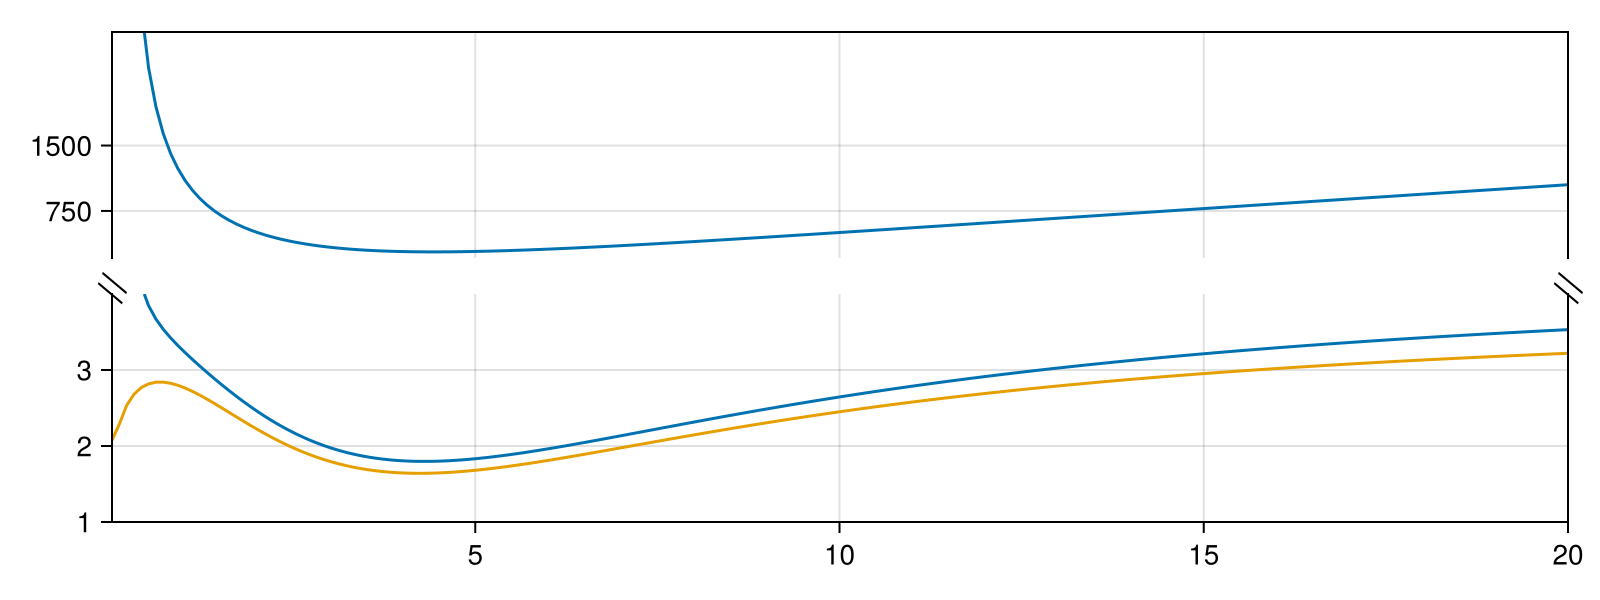

In [102]:
x_low = the_range
y_low = 𝒬Cio
x_high = the_range
y_high = 𝒬C

low_lims = (1, 4)
high_lims = (minimum(𝒬C)*0.75, minimum(𝒬C)*10)

fig = Figure(size=(800, 300))
gd = fig[1, 1] = GridLayout()
    # Create upper and lower axes
ax_top = Axis(gd[1, 1], yticks = [750, 1500])
ax_bottom = Axis(gd[2, 1], yticks = [1, 2, 3])

# Plot the data
lines!(ax_bottom, the_range, 𝒬Cio)
lines!(ax_bottom, the_range, 𝒬P_sc)
lines!(ax_top, x_high, 𝒬C)

set_broken_axis!(ax_top, ax_bottom, the_range , high_lims, low_lims)
add_figure_break_indicators!(fig, (0.07, 0.52), (0.98, 0.52))

fig

## Example Usage

Here's how to use the piecewise plotting functionality:

In [ ]:
x_low = the_range
y_low = 𝒬Cio
x_high = the_range
y_high = 𝒬C

low_lims = (1, 4)
high_lims = (minimum(𝒬C)*0.75, minimum(𝒬C)*10)

fig = Figure(size=(800, 300))
gd = fig[1, 1] = GridLayout()
    # Create upper and lower axes
ax_top = Axis(gd[1, 1], yticks = [750, 1500])
ax_bottom = Axis(gd[2, 1], yticks = [1, 2, 3])

# Plot the data
lines!(ax_bottom, the_range, 𝒬Cio)
lines!(ax_bottom, the_range, 𝒬P_sc)
lines!(ax_top, x_high, 𝒬C)

set_broken_axis!(ax_top, ax_bottom, the_range , high_lims, low_lims)
add_figure_break_indicators!(fig, (0.07, 0.52), (0.98, 0.52))

fig